In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils import *
from Network import *

import matplotlib.pyplot as plt
import glob
import time

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = True

In [19]:
out = nn.LSTM(input_size = 15, hidden_size =64, num_layers =5, bidirectional=False, dropout =0.2, batch_first=True)(torch.Tensor(32,20,15))
out[0].shape, out[1][0].shape, out[1][1].shape

(torch.Size([32, 20, 64]), torch.Size([5, 32, 64]), torch.Size([5, 32, 64]))

In [8]:
# hyperparams
enc_seq_len = 20
dec_seq_len = 3
output_sequence_length = 0

dim_val = 32
dim_attn = 5
lr = 0.05
epochs = 20

batch_size = 32
input_size = 15

n_heads = 3
# init network and optimizer
# dim_val*2

class BoostRNN(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, n_layers, n_heads):
        super(BoostRNN, self).__init__()
        self.n_layers = n_layers
        self.dim_val = dim_val
        
        self.rnn = nn.LSTM(input_size = input_size, hidden_size =dim_val, num_layers =n_layers, bidirectional=False, dropout =0.2, batch_first=True)
        self.rnn2 = nn.LSTM(input_size = 7, hidden_size =dim_val, num_layers =n_layers, bidirectional=False, dropout =0.2, batch_first=True)

        self.fc0 = nn.Linear(input_size, dim_val*2)
        self.fc1 = nn.Linear(dim_val*2, dim_val*2)
        self.fc2 = nn.Linear(dim_val*2, 1)

        self.fc3 = nn.Linear(dim_val*2, dim_val*2)
        self.fc4 = nn.Linear(dim_val*2, 1)
        
        self.alpha = torch.nn.parameter.Parameter(torch.Tensor(1))

    def forward(self, x):
        xx = x[:, :, [0, 2, 10, 11, 12, 13, 14]]
        
        # x = self.fc0(x)
        x, (hn, cn) = self.rnn(x)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1) 
        x = self.fc2(F.elu(self.fc1(hn)))
        
        xx, (hn, cn) = self.rnn2(xx)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1) 
        xx = self.fc4(F.elu(self.fc3(hn)))

        x = torch.sigmoid(self.alpha) * x + (1 - torch.sigmoid(self.alpha)) * xx
        return x



class RNN(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, n_layers, n_heads):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.dim_val = dim_val
        
        self.rnn = nn.LSTM(input_size = input_size, hidden_size =dim_val, num_layers =n_layers, bidirectional=False, dropout =0.2, batch_first=True)

        self.fc1 = nn.Linear(dim_val*2, dim_val*2)
        self.fc2 = nn.Linear(dim_val*2, 1)

        self.fc3 = nn.Linear(dim_val*2, dim_val*2)
        self.fc4 = nn.Linear(dim_val*2, 1)

    def forward(self, x):
        # x = self.fc0(x)
        x, (hn, cn) = self.rnn(x)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1) 
        x = self.fc2(F.elu(self.fc1(hn)))
        xx = self.fc4(F.elu(self.fc3(hn)))
        return x, xx

    
class SelectRNN(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, n_layers, n_heads):
        super(SelectRNN, self).__init__()
        self.n_layers = n_layers
        self.dim_val = dim_val
        
        self.rnn = nn.LSTM(input_size = input_size, hidden_size =dim_val, num_layers =n_layers, bidirectional=False, dropout =0.2, batch_first=True)
        
        self.fc1 = nn.Linear(dim_val*2, dim_val*2)
        self.fc2 = nn.Linear(dim_val*2, 1)

        self.key1 = Key(input_size, input_size)
        self.query1 = Query(input_size, input_size)
        
        self.key2 = Key(input_size, input_size)
        self.query2 = Query(input_size, input_size)
        
    def forward(self, x):
        m1 = torch.matmul(self.query1(x), self.key1(x).transpose(2,1).float())
        m2 = torch.matmul(self.query2(x).transpose(2,1).float(), self.key2(x))
        p1 = torch.softmax(torch.mean(m1, -1), -1).unsqueeze(2)
        p2 = torch.softmax(torch.mean(m2, -1), -1).unsqueeze(1)

        x = x * p2
        x, (hn, cn) = self.rnn(x)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1) 
        x = self.fc2(F.elu(self.fc1(hn)))
        return x, (p1, p2)
                
class AttentionRNN(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, n_layers, n_heads):
        super(AttentionRNN, self).__init__()
        self.n_layers = n_layers
        self.dim_val = dim_val
        
        self.fc1 = nn.Linear(input_size, dim_val)

        self.attn = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.norm = nn.LayerNorm(dim_val)
        self.rnn = nn.LSTM(input_size = dim_val, hidden_size =dim_val, num_layers =n_layers, bidirectional=False, dropout =0.2, batch_first=True)

        self.fc2 = nn.Linear(dim_val*2, dim_val*2)
        self.fc3 = nn.Linear(dim_val*2, 1)

    def forward(self, x):
        x = self.fc1(x)
        a = self.attn(x)
        x = self.norm(a + x)
        
        x, (hn, cn) = self.rnn(x)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1) 
        x = self.fc3(F.elu(self.fc2(hn)))
        return x
    
    
class CNN(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, n_layers, n_heads):
        super(CNN, self).__init__()
        self.n_layers = n_layers
        self.dim_val = dim_val

        self.conv = nn.Conv2d(input_size, dim_val, (1, 1))

        self.conv1 = nn.Conv2d(input_size, dim_val, (3, 1), padding=(1, 0))
        self.conv2 = nn.Conv2d(input_size, dim_val, (5, 1), padding=(2, 0))
        self.conv3 = nn.Conv2d(input_size, dim_val, (7, 1), padding=(3, 0))
   
        self.pool = nn.AdaptiveMaxPool2d((1 ,1))

        self.pool1 = nn.AdaptiveMaxPool2d((1 ,1))
        self.pool2 = nn.AdaptiveMaxPool2d((1 ,1))
        self.pool3 = nn.AdaptiveMaxPool2d((1 ,1))
        
        self.bn = nn.BatchNorm2d(dim_val)

        self.bn1 = nn.BatchNorm2d(dim_val)
        self.bn2 = nn.BatchNorm2d(dim_val)
        self.bn3 = nn.BatchNorm2d(dim_val)
        
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(dim_val*3, 1)
        self.fc1 = nn.Linear(dim_val*3, dim_val)
        self.fc2 = nn.Linear(dim_val, 1)

    def forward(self, x):
        x = x.unsqueeze(3)
        x = x.transpose(2, 1)
        
        x1 = F.elu(self.conv1(x))
        x2 = F.elu(self.conv2(x))
        x3 = F.elu(self.conv3(x))
        
        x = torch.cat([x1, x2, x3], dim=1)
        x = self.pool(x)
        
        x = x.flatten(start_dim=1)
        x = self.dropout(x)
        # x = self.fc2(F.tanh(self.fc1(x)))
        x = self.fc(x)
        return x

    
class SimpleCNN(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, n_layers, n_heads):
        super(SimpleCNN, self).__init__()
        self.n_layers = n_layers
        self.dim_val = dim_val

        self.conv1 = nn.Conv2d(1, dim_val, (3, 3))
        self.conv2 = nn.Conv2d(dim_val, dim_val*2, (3, 3))
        self.conv3 = nn.Conv2d(dim_val*2, dim_val*2, (3, 3))
        
        self.pool = nn.AdaptiveAvgPool2d((1 ,1))
        
        self.bn1 = nn.BatchNorm2d(dim_val)
        self.bn2 = nn.BatchNorm2d(dim_val*2)
        self.bn3 = nn.BatchNorm2d(dim_val*2)
        
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(dim_val*2, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.bn1(F.elu(self.conv1(x)))
        x = self.bn2(F.elu(self.conv2(x)))
        x = self.bn3(F.elu(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.fc(x.flatten(start_dim=1))
        return x

    
t1 = RNN(dim_val, dim_attn, input_size, n_layers=2, n_heads=n_heads)
t1.cuda()

# t2 = RNN(dim_val, dim_attn, input_size, n_layers=2, n_heads=n_heads)
optimizer1 = torch.optim.SGD(t1.parameters(), lr=lr, weight_decay=0.01)
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, 
                                                        mode='min', 
                                                        factor=0.9, 
                                                        patience=10, 
                                                        verbose=False, 
                                                        threshold=0.0001, 
                                                        threshold_mode='rel', 
                                                        cooldown=0, 
                                                        min_lr=0, 
                                                        eps=1e-08)
# optimizer2 = torch.optim.SGD(t1.parameters(), lr=lr)
# t2.cuda()

print('success')

success


In [3]:
import h5py
import numpy as np

class FileIter():
    def __init__(self, f, enc_seq_len=20):
        self.name = f
        self.f = h5py.File(f, 'r')
        self.n = len(self.f['timestamp'])
        self.indexes = np.arange(self.n)
        self.batch_size = batch_size
        self.index = 0
        self.mask = list(range(15)) #[1, 3, 4, 5, 6, 7, 8, 9]# [0, 2, 10, 11, 12, 13, 14]
        
    def __getitem__(self, i):
        batch_index = self.indexes[i * self.batch_size : (i + 1) * self.batch_size]
        X = self.f['x'][batch_index, -enc_seq_len:, :]
        Y = self.f['y'][batch_index]
        X = torch.tensor(X[:, :, np.array(self.mask)]).cuda()  
        # X = torch.tensor(X).cuda() 
        Y = torch.tensor(Y).cuda()
        return X, Y
    
    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))
        
    def next_item(self):
        if self.index >= self.__len__():
            self.index = 0
        X, Y = self.__getitem__(self.index)
        self.index += 1
        return X, Y
        
tmp_l =  glob.glob('../stockprice/train/*.hdf')
tmp_l.remove('../stockprice/train/20190425_20190510.hdf')
train_fs = [FileIter(f) for f in tmp_l]
test_fs = [FileIter(f) for f in glob.glob('../stockprice/test/*.hdf')]
sum_n = np.sum([f.n for f in train_fs])

tensor(0.9375, device='cuda:0')
torch.Size([16, 1])
0.9875233769416809


-1.1535197701434576

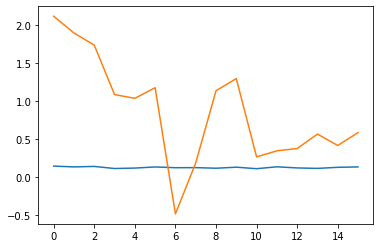

In [4]:
tst_X, tst_Y = test_fs[np.random.randint(len(test_fs))].next_item()
t1.eval()
# net_out, a = t1(tst_X)
# plt.plot(a[0][0][:,0].cpu().detach().numpy())
# plt.show()

# plt.plot(a[1][0][0].cpu().detach().numpy())
# plt.show()

# plt.imshow((a[0][0] * a[1][0]).cpu().detach().numpy())
# plt.show()
net_out = t1(tst_X)[0]

print(torch.mean(torch.gt(net_out * tst_Y, 0).float()))
print(net_out.shape)
net_out = np.squeeze(net_out.detach().cpu().numpy())
tst_Y = np.squeeze(tst_Y.cpu().numpy())
np.sum((tst_Y - net_out)**2) / batch_size
plt.plot(net_out)
plt.plot(tst_Y)
print(np.sum((net_out - tst_Y)**2)/batch_size)
r2 = 1 - np.sum((net_out - tst_Y)**2) /(np.sum((tst_Y - np.mean(tst_Y))**2) + 1e-4)
r2

In [5]:
print('='*10)
# keep track of loss for graph
losses = []
r2_list = []
rate_list = []

train_loss = None
train_r2 = None
train_rate = None
train_acc = None

metrics_loss = None
metrics_r2 = None
metrics_rate = None
metrics_acc = None

train_file_index = 0
test_file_index = 0

f_r2 = lambda x, y: 1 - torch.sum((x - y)**2) /(torch.sum((y - torch.mean(y))**2) + 1e-4)
f_rate = lambda x, y: torch.mean(torch.gt(x * y, 0).float())
f_average = lambda x, y : x.cpu() # if y is None else 0.8*y + 0.2 *x.cpu()
f_acc = lambda x, y: torch.mean(torch.eq(torch.gt(x, 0.5).int(), y).float())

print(sum_n//batch_size - 1)

251172


In [6]:
# 32-2
# from Network import RNN
t1 = RNN(64, dim_attn, input_size, n_layers=4, n_heads=n_heads)
t1.cuda()
optimizer1 = torch.optim.SGD(t1.parameters(), lr=lr, weight_decay=0.01)
t1.train()

while True:
    X, Y = train_fs[train_file_index % len(train_fs)].next_item()
    optimizer1.zero_grad()
    net_out = t1(X)
    loss1 = F.binary_cross_entropy_with_logits(net_out[1], torch.gt(Y, 0).float()) + torch.mean((net_out[0] - Y) ** 2) + 0.3 * torch.sum((net_out[0] - Y)**2) /(torch.sum((Y - torch.mean(Y))**2) + 1e-4) #
    loss1.backward()
    optimizer1.step()
    print(loss1, f_r2(net_out[0], Y))

tensor(1.2526, device='cuda:0', grad_fn=<AddBackward0>) tensor(-0.2971, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(1.2258, device='cuda:0', grad_fn=<AddBackward0>) tensor(-0.0057, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(2.0917, device='cuda:0', grad_fn=<AddBackward0>) tensor(-2.3840, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(1.3398, device='cuda:0', grad_fn=<AddBackward0>) tensor(-0.4464, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(5.9556, device='cuda:0', grad_fn=<AddBackward0>) tensor(-1.8125, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(15.7481, device='cuda:0', grad_fn=<AddBackward0>) tensor(-18.6500, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(3.8053, device='cuda:0', grad_fn=<AddBackward0>) tensor(-0.0410, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(9.9928, device='cuda:0', grad_fn=<AddBackward0>) tensor(-5.3689, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(6.1717, device='cuda:0', grad_fn=<AddBackward0>) tensor(-1.0906, device='cuda:0

tensor(1.5417, device='cuda:0', grad_fn=<AddBackward0>) tensor(-0.5742, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(1.6466, device='cuda:0', grad_fn=<AddBackward0>) tensor(-0.0826, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(4.7765, device='cuda:0', grad_fn=<AddBackward0>) tensor(-2.1048, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(2.4520, device='cuda:0', grad_fn=<AddBackward0>) tensor(-0.8744, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(1.9647, device='cuda:0', grad_fn=<AddBackward0>) tensor(-1.3506, device='cuda:0', grad_fn=<RsubBackward1>)


KeyboardInterrupt: 

In [9]:
epochs = 40
for e in range(0, epochs):
    out = []
    for b in range(sum_n//batch_size - 1):
        t1.train()
        # t2.train()
        optimizer1.zero_grad()
        # optimizer2.zero_grad()

        X, Y = train_fs[train_file_index % len(train_fs)].next_item()
        train_file_index += 1

        #Forward pass and calculate loss
        net_out = t1(X)
        #print(net_out.shape,Y.shape)
        loss1 = torch.mean((net_out[0] - Y) ** 2) + F.binary_cross_entropy_with_logits(net_out[1], torch.gt(Y, 0).float())
        net_out = net_out[0]
        if b % 100 == 0:
            scheduler1.step(loss1)
        #backwards pass
        loss1.backward()
        nn.utils.clip_grad_norm_(t1.parameters(), max_norm=20, norm_type=2)
        optimizer1.step()
        
        # ============================= #
        
#         #Forward pass and calculate loss
#         net_out = t2(X)
#         #print(net_out.shape,Y.shape)
#         loss2 = torch.mean((net_out - Y) ** 2)
#         #backwards pass
#         loss2.backward()
#         nn.utils.clip_grad_norm_(t2.parameters(), max_norm=20, norm_type=2)
#         optimizer2.step()
        
        
        if b % 100 == 0:
            t1.eval()
            # t2.eval()
            # net_out = (t1(X) + t2(X)) / 2
            # train
            X, Y = train_fs[train_file_index % len(train_fs)].next_item()
            net_out = t1(X)
            loss = torch.mean((net_out[0] - Y) ** 2)+ F.binary_cross_entropy_with_logits(net_out[1], torch.gt(Y, 0).float())

            r2 = f_r2(net_out[0], Y)
            rate = f_rate(net_out[0], Y)
            acc = f_acc(net_out[1], torch.gt(Y, 0))
            
            train_loss = f_average(loss, train_loss)
            train_rate = f_average(rate, train_rate)
            train_r2 = f_average(r2, train_r2)
            train_acc = f_average(acc, train_acc)

            # test
            tst_X, tst_Y = test_fs[test_file_index%len(test_fs)].next_item()
            test_file_index += 1
            
            # net_out = (t1(tst_X) + t2(tst_X)) / 2
            with torch.no_grad():
                net_out  = t1(tst_X)
            loss = torch.mean((net_out[0] - tst_Y) ** 2)+ F.binary_cross_entropy_with_logits(net_out[1], torch.gt(tst_Y, 0).float())

            r2 = f_r2(net_out[0], tst_Y)
            rate = f_rate(net_out[0], tst_Y)
            acc = f_acc(net_out[1], torch.gt(tst_Y, 0))

            metrics_loss = f_average(loss, metrics_loss)
            metrics_rate = f_average(rate, metrics_rate)
            metrics_r2 = f_average(r2, metrics_r2)
            metrics_acc = f_average(acc, metrics_acc)

            print('epoch:{} step:{}'.format(e, b), 'train loss: {:.3f}, r2: {:.3f}, rate:{:.3f}, acc:{:.3f}'.format(train_loss, train_r2, train_rate, train_acc), 'val loss: {:.3f}, r2: {:.3f}, rate:{:.3f}, acc:{:.3f}'.format(metrics_loss, metrics_r2, metrics_rate, metrics_acc), 'lr', optimizer1.state_dict()['param_groups'][0]['lr'])
    # eval
    t1.eval()
    avg_r2 = []
    for eval_test_file_index in range(len(test_fs)):
        mask = test_fs[eval_test_file_index].mask
        eval_X = test_fs[eval_test_file_index].f['x'][:][:,:,mask]
        eval_Y = test_fs[eval_test_file_index].f['y'][:]

        eval_X = torch.Tensor(eval_X).cuda()
        net_out = t1(eval_X)[0].cpu().detach().numpy()
        r2 = 1 - np.sum((net_out - eval_Y)**2) /(np.sum((eval_Y - np.mean(eval_Y))**2) + 1e-4)
        avg_r2.append(r2)
    with open('model/epoch_{}_r2_{:.3f}.txt'.format(e, float(np.mean(avg_r2))), 'w') as f:
        for eval_test_file_index, r2 in enumerate(avg_r2):
            f.write(test_fs[eval_test_file_index].name + ' ' + '{:.3f}'.format(r2) + '\n')
    torch.save({'state_dict': t1.state_dict()}, 'model/rnn_sgd_scheduler_0.01_model_epoch_{}_r2_{:.3f}.pth.tar'.format(e, float(np.mean(avg_r2))))
    
    print('epoch:{} step:{:.3f}'.format(e, np.mean(avg_r2)), 'lr {:.6f}'.format(optimizer1.state_dict()['param_groups'][0]['lr']))

epoch:0 step:0 train loss: 3.070, r2: -0.022, rate:0.312, acc:0.688 val loss: 1.419, r2: -0.033, rate:0.375, acc:0.625 lr 0.05
epoch:0 step:100 train loss: 0.817, r2: 0.193, rate:0.562, acc:0.562 val loss: 0.845, r2: 0.165, rate:0.500, acc:0.750 lr 0.05
epoch:0 step:200 train loss: 3.631, r2: -0.844, rate:0.812, acc:0.188 val loss: 1.104, r2: 0.372, rate:0.625, acc:0.562 lr 0.05
epoch:0 step:300 train loss: 0.816, r2: -0.207, rate:0.812, acc:0.562 val loss: 1.324, r2: -0.309, rate:0.562, acc:0.688 lr 0.05
epoch:0 step:400 train loss: 1.632, r2: 0.026, rate:0.625, acc:0.688 val loss: 1.666, r2: -0.634, rate:0.812, acc:0.375 lr 0.05
epoch:0 step:500 train loss: 0.937, r2: -1.394, rate:0.688, acc:0.438 val loss: 0.833, r2: 0.259, rate:0.812, acc:0.562 lr 0.05
epoch:0 step:600 train loss: 1.475, r2: -0.262, rate:0.938, acc:0.438 val loss: 0.993, r2: 0.335, rate:0.875, acc:0.375 lr 0.05
epoch:0 step:700 train loss: 1.235, r2: -2.019, rate:0.375, acc:0.750 val loss: 1.320, r2: -3.534, rate:0

epoch:0 step:6000 train loss: 1.549, r2: 0.437, rate:0.688, acc:0.750 val loss: 1.858, r2: -0.115, rate:0.438, acc:0.500 lr 0.03280500000000001
epoch:0 step:6100 train loss: 0.774, r2: 0.530, rate:0.750, acc:0.750 val loss: 1.269, r2: -0.461, rate:0.688, acc:0.438 lr 0.03280500000000001
epoch:0 step:6200 train loss: 0.825, r2: -1.654, rate:0.625, acc:1.000 val loss: 5.185, r2: -0.362, rate:0.312, acc:0.500 lr 0.03280500000000001
epoch:0 step:6300 train loss: 0.801, r2: -1.491, rate:0.688, acc:0.812 val loss: 1.013, r2: 0.051, rate:0.562, acc:0.938 lr 0.03280500000000001
epoch:0 step:6400 train loss: 1.537, r2: -1.288, rate:0.625, acc:1.000 val loss: 0.935, r2: 0.095, rate:0.562, acc:0.688 lr 0.03280500000000001
epoch:0 step:6500 train loss: 1.220, r2: 0.108, rate:0.688, acc:0.625 val loss: 0.588, r2: -0.846, rate:0.750, acc:0.938 lr 0.03280500000000001
epoch:0 step:6600 train loss: 0.705, r2: 0.598, rate:0.875, acc:0.750 val loss: 1.417, r2: -0.588, rate:0.375, acc:0.375 lr 0.032805000

epoch:1 step:3800 train loss: 1.317, r2: 0.353, rate:0.438, acc:0.562 val loss: 0.641, r2: 0.357, rate:0.688, acc:0.750 lr 0.01937102445000001
epoch:1 step:3900 train loss: 0.689, r2: -0.097, rate:0.812, acc:0.375 val loss: 0.851, r2: 0.402, rate:0.688, acc:0.625 lr 0.01937102445000001
epoch:1 step:4000 train loss: 1.244, r2: -0.565, rate:0.562, acc:0.562 val loss: 0.840, r2: -0.423, rate:0.750, acc:0.625 lr 0.01937102445000001
epoch:1 step:4100 train loss: 0.635, r2: -0.548, rate:0.812, acc:0.812 val loss: 2.640, r2: 0.394, rate:0.750, acc:0.750 lr 0.01937102445000001
epoch:1 step:4200 train loss: 2.356, r2: -0.180, rate:0.938, acc:0.812 val loss: 0.876, r2: 0.305, rate:0.625, acc:0.562 lr 0.01937102445000001
epoch:1 step:4300 train loss: 1.154, r2: -0.920, rate:0.375, acc:0.562 val loss: 1.275, r2: 0.042, rate:0.500, acc:0.500 lr 0.01937102445000001
epoch:1 step:4400 train loss: 0.754, r2: -0.082, rate:0.812, acc:0.812 val loss: 1.037, r2: -0.719, rate:0.500, acc:0.438 lr 0.019371024

epoch:2 step:1600 train loss: 1.093, r2: -19.296, rate:0.062, acc:0.875 val loss: 1.009, r2: -1.246, rate:0.625, acc:0.688 lr 0.011438396227480507
epoch:2 step:1700 train loss: 0.747, r2: -3.706, rate:0.688, acc:0.500 val loss: 0.769, r2: 0.200, rate:0.750, acc:0.875 lr 0.011438396227480507
epoch:2 step:1800 train loss: 0.668, r2: 0.258, rate:0.625, acc:0.750 val loss: 1.932, r2: -0.493, rate:0.500, acc:0.500 lr 0.011438396227480507
epoch:2 step:1900 train loss: 0.610, r2: 0.083, rate:0.750, acc:0.625 val loss: 1.490, r2: -0.606, rate:0.625, acc:0.812 lr 0.011438396227480507
epoch:2 step:2000 train loss: 1.043, r2: -1.146, rate:0.625, acc:0.250 val loss: 0.982, r2: 0.413, rate:0.938, acc:0.875 lr 0.011438396227480507
epoch:2 step:2100 train loss: 1.303, r2: -0.272, rate:0.312, acc:0.750 val loss: 1.249, r2: -0.224, rate:0.438, acc:0.500 lr 0.011438396227480507
epoch:2 step:2200 train loss: 0.654, r2: 0.305, rate:0.750, acc:0.875 val loss: 1.062, r2: -0.556, rate:0.750, acc:0.688 lr 0.0

epoch:2 step:7300 train loss: 0.577, r2: 0.204, rate:0.938, acc:0.688 val loss: 0.555, r2: 0.767, rate:0.938, acc:0.688 lr 0.006754258588364966
epoch:2 step:7400 train loss: 2.076, r2: -0.093, rate:0.812, acc:0.750 val loss: 0.941, r2: -0.978, rate:0.562, acc:0.562 lr 0.006754258588364966
epoch:2 step:7500 train loss: 0.716, r2: 0.261, rate:0.688, acc:0.938 val loss: 4.000, r2: -3.688, rate:0.562, acc:0.375 lr 0.006754258588364966
epoch:2 step:7600 train loss: 0.787, r2: -0.641, rate:0.625, acc:0.562 val loss: 0.897, r2: 0.395, rate:0.688, acc:0.625 lr 0.006754258588364966
epoch:2 step:7700 train loss: 0.907, r2: -0.757, rate:0.688, acc:0.688 val loss: 0.522, r2: 0.538, rate:0.812, acc:0.875 lr 0.006754258588364966
epoch:2 step:7800 train loss: 2.292, r2: -3.393, rate:0.375, acc:0.875 val loss: 3.179, r2: -0.257, rate:0.375, acc:0.688 lr 0.00607883272952847
epoch:2 step:0.308 lr 0.006079
epoch:3 step:0 train loss: 0.738, r2: -0.541, rate:0.562, acc:0.750 val loss: 1.164, r2: 0.375, rat

epoch:3 step:5100 train loss: 0.607, r2: 0.395, rate:0.875, acc:0.812 val loss: 0.750, r2: 0.439, rate:0.875, acc:0.875 lr 0.0039883221538436296
epoch:3 step:5200 train loss: 0.904, r2: -1.784, rate:0.562, acc:0.562 val loss: 0.915, r2: 0.266, rate:0.750, acc:0.688 lr 0.0039883221538436296
epoch:3 step:5300 train loss: 0.920, r2: 0.642, rate:0.750, acc:0.688 val loss: 0.821, r2: -0.371, rate:0.625, acc:0.438 lr 0.0039883221538436296
epoch:3 step:5400 train loss: 0.716, r2: 0.668, rate:0.750, acc:0.938 val loss: 1.621, r2: -7.940, rate:0.188, acc:0.625 lr 0.003589489938459267
epoch:3 step:5500 train loss: 0.656, r2: -0.364, rate:0.562, acc:0.750 val loss: 0.703, r2: 0.334, rate:0.812, acc:0.812 lr 0.003589489938459267
epoch:3 step:5600 train loss: 3.486, r2: -0.187, rate:0.812, acc:0.875 val loss: 0.997, r2: 0.055, rate:0.625, acc:0.875 lr 0.003589489938459267
epoch:3 step:5700 train loss: 1.178, r2: -0.433, rate:0.688, acc:0.562 val loss: 0.724, r2: 0.575, rate:0.875, acc:0.688 lr 0.00

epoch:4 step:2900 train loss: 0.911, r2: -0.879, rate:0.625, acc:0.750 val loss: 1.016, r2: 0.174, rate:0.688, acc:0.188 lr 0.002355064348623125
epoch:4 step:3000 train loss: 0.655, r2: 0.383, rate:0.812, acc:0.625 val loss: 0.625, r2: 0.694, rate:0.750, acc:0.500 lr 0.002119557913760813
epoch:4 step:3100 train loss: 0.802, r2: -0.045, rate:0.562, acc:0.562 val loss: 0.656, r2: -1.736, rate:0.812, acc:0.938 lr 0.002119557913760813
epoch:4 step:3200 train loss: 0.806, r2: -1.659, rate:0.500, acc:0.688 val loss: 0.901, r2: -0.315, rate:0.625, acc:0.500 lr 0.002119557913760813
epoch:4 step:3300 train loss: 1.101, r2: -2.898, rate:0.438, acc:0.375 val loss: 1.550, r2: -0.153, rate:0.688, acc:0.875 lr 0.002119557913760813
epoch:4 step:3400 train loss: 0.720, r2: -0.455, rate:0.438, acc:0.188 val loss: 0.979, r2: 0.306, rate:0.438, acc:0.438 lr 0.002119557913760813
epoch:4 step:3500 train loss: 1.081, r2: 0.458, rate:0.875, acc:0.938 val loss: 0.866, r2: -0.450, rate:0.625, acc:0.812 lr 0.00

epoch:5 step:600 train loss: 1.161, r2: -3.243, rate:0.562, acc:0.875 val loss: 1.120, r2: -2.390, rate:0.688, acc:0.562 lr 0.0012515777524966226
epoch:5 step:700 train loss: 0.607, r2: 0.655, rate:0.812, acc:0.438 val loss: 0.924, r2: -1.404, rate:0.562, acc:0.875 lr 0.0012515777524966226
epoch:5 step:800 train loss: 1.065, r2: -0.091, rate:0.438, acc:0.062 val loss: 0.842, r2: 0.016, rate:0.500, acc:0.312 lr 0.0012515777524966226
epoch:5 step:900 train loss: 0.825, r2: -0.779, rate:0.562, acc:0.375 val loss: 1.236, r2: 0.437, rate:0.562, acc:0.500 lr 0.0012515777524966226
epoch:5 step:1000 train loss: 0.914, r2: 0.534, rate:0.625, acc:0.375 val loss: 0.692, r2: 0.491, rate:0.688, acc:0.812 lr 0.0012515777524966226
epoch:5 step:1100 train loss: 1.875, r2: -0.163, rate:0.938, acc:0.938 val loss: 1.109, r2: 0.445, rate:0.688, acc:0.688 lr 0.0012515777524966226
epoch:5 step:1200 train loss: 1.696, r2: -0.391, rate:0.812, acc:0.750 val loss: 2.149, r2: -6.203, rate:0.875, acc:0.688 lr 0.0

epoch:5 step:6300 train loss: 0.888, r2: 0.483, rate:0.562, acc:0.562 val loss: 0.780, r2: -0.564, rate:0.750, acc:0.562 lr 0.0007390441470717307
epoch:5 step:6400 train loss: 0.658, r2: 0.534, rate:0.688, acc:0.688 val loss: 1.472, r2: -0.189, rate:0.500, acc:0.438 lr 0.0007390441470717307
epoch:5 step:6500 train loss: 0.900, r2: 0.634, rate:0.688, acc:0.812 val loss: 1.477, r2: -0.775, rate:0.625, acc:0.688 lr 0.0007390441470717307
epoch:5 step:6600 train loss: 0.954, r2: -0.374, rate:0.500, acc:0.625 val loss: 0.717, r2: 0.051, rate:0.500, acc:0.875 lr 0.0007390441470717307
epoch:5 step:6700 train loss: 0.476, r2: 0.843, rate:0.938, acc:0.938 val loss: 0.975, r2: 0.125, rate:0.625, acc:0.625 lr 0.0007390441470717307
epoch:5 step:6800 train loss: 0.748, r2: -0.797, rate:0.688, acc:0.562 val loss: 1.162, r2: -1.770, rate:0.500, acc:0.250 lr 0.0007390441470717307
epoch:5 step:6900 train loss: 0.717, r2: 0.452, rate:0.812, acc:0.875 val loss: 0.933, r2: 0.281, rate:0.438, acc:0.500 lr 0

epoch:6 step:4000 train loss: 0.502, r2: 0.820, rate:0.875, acc:0.938 val loss: 0.730, r2: 0.105, rate:0.750, acc:0.875 lr 0.0004363981784043862
epoch:6 step:4100 train loss: 2.793, r2: 0.389, rate:0.688, acc:0.688 val loss: 2.049, r2: -1.308, rate:0.688, acc:0.500 lr 0.0004363981784043862
epoch:6 step:4200 train loss: 1.037, r2: -3.345, rate:0.375, acc:0.125 val loss: 2.029, r2: -0.813, rate:0.688, acc:0.812 lr 0.0004363981784043862
epoch:6 step:4300 train loss: 0.646, r2: 0.269, rate:0.812, acc:0.500 val loss: 0.656, r2: -1.202, rate:0.688, acc:0.500 lr 0.0004363981784043862
epoch:6 step:4400 train loss: 0.761, r2: -0.777, rate:0.750, acc:0.938 val loss: 0.696, r2: 0.544, rate:0.750, acc:0.938 lr 0.0004363981784043862
epoch:6 step:4500 train loss: 1.147, r2: -0.004, rate:0.750, acc:0.312 val loss: 0.795, r2: 0.242, rate:0.562, acc:0.688 lr 0.0004363981784043862
epoch:6 step:4600 train loss: 0.806, r2: -0.748, rate:0.375, acc:0.688 val loss: 1.148, r2: 0.158, rate:0.812, acc:0.500 lr 

epoch:7 step:1700 train loss: 0.953, r2: -0.114, rate:0.812, acc:0.562 val loss: 0.730, r2: -1.013, rate:0.500, acc:0.500 lr 0.00025768876036600606
epoch:7 step:1800 train loss: 0.959, r2: -0.477, rate:0.500, acc:0.312 val loss: 1.656, r2: -1.343, rate:0.375, acc:0.688 lr 0.00025768876036600606
epoch:7 step:1900 train loss: 0.740, r2: 0.219, rate:0.750, acc:0.562 val loss: 0.756, r2: -0.008, rate:0.688, acc:0.625 lr 0.00025768876036600606
epoch:7 step:2000 train loss: 1.961, r2: -2.793, rate:0.250, acc:0.125 val loss: 1.187, r2: -1.729, rate:0.688, acc:0.500 lr 0.00025768876036600606
epoch:7 step:2100 train loss: 0.695, r2: 0.242, rate:0.750, acc:0.938 val loss: 0.745, r2: 0.259, rate:0.812, acc:0.562 lr 0.00025768876036600606
epoch:7 step:2200 train loss: 0.777, r2: -0.088, rate:0.750, acc:0.812 val loss: 0.865, r2: -0.483, rate:0.688, acc:0.438 lr 0.00025768876036600606
epoch:7 step:2300 train loss: 0.808, r2: 0.042, rate:0.688, acc:0.375 val loss: 2.659, r2: 0.106, rate:0.500, acc:0

epoch:7 step:7300 train loss: 0.779, r2: -0.158, rate:0.562, acc:0.875 val loss: 0.687, r2: -0.223, rate:0.625, acc:0.812 lr 0.00015216263610852294
epoch:7 step:7400 train loss: 0.843, r2: 0.551, rate:0.750, acc:0.750 val loss: 0.870, r2: -0.039, rate:0.562, acc:0.625 lr 0.00015216263610852294
epoch:7 step:7500 train loss: 0.924, r2: -2.164, rate:0.625, acc:0.750 val loss: 1.186, r2: 0.282, rate:0.562, acc:0.562 lr 0.00015216263610852294
epoch:7 step:7600 train loss: 0.905, r2: -0.386, rate:0.562, acc:0.812 val loss: 2.996, r2: -2.555, rate:0.625, acc:0.438 lr 0.00015216263610852294
epoch:7 step:7700 train loss: 3.288, r2: -0.501, rate:0.938, acc:1.000 val loss: 1.064, r2: 0.335, rate:0.625, acc:0.688 lr 0.00015216263610852294
epoch:7 step:7800 train loss: 0.827, r2: 0.593, rate:0.625, acc:0.688 val loss: 0.979, r2: -2.814, rate:0.562, acc:1.000 lr 0.00015216263610852294
epoch:7 step:0.315 lr 0.000152
epoch:8 step:0 train loss: 0.719, r2: 0.539, rate:0.625, acc:0.625 val loss: 0.951, r

epoch:8 step:5000 train loss: 1.240, r2: -0.331, rate:0.750, acc:1.000 val loss: 0.651, r2: 0.136, rate:0.812, acc:0.562 lr 8.985051499572172e-05
epoch:8 step:5100 train loss: 0.555, r2: 0.815, rate:0.812, acc:0.812 val loss: 1.021, r2: -2.102, rate:0.750, acc:0.875 lr 8.985051499572172e-05
epoch:8 step:5200 train loss: 0.701, r2: -1.045, rate:0.625, acc:0.312 val loss: 1.213, r2: 0.182, rate:0.688, acc:0.625 lr 8.985051499572172e-05
epoch:8 step:5300 train loss: 1.504, r2: -0.377, rate:0.812, acc:0.625 val loss: 0.870, r2: 0.444, rate:0.750, acc:0.625 lr 8.985051499572172e-05
epoch:8 step:5400 train loss: 0.562, r2: 0.311, rate:0.875, acc:0.938 val loss: 1.374, r2: 0.642, rate:0.438, acc:0.438 lr 8.985051499572172e-05
epoch:8 step:5500 train loss: 1.188, r2: -9.217, rate:0.625, acc:0.562 val loss: 1.050, r2: -0.908, rate:0.562, acc:0.500 lr 8.086546349614955e-05
epoch:8 step:5600 train loss: 6.008, r2: -17.617, rate:0.938, acc:0.625 val loss: 0.532, r2: -0.599, rate:0.750, acc:1.000 l

epoch:9 step:2800 train loss: 1.455, r2: -3.287, rate:0.438, acc:0.312 val loss: 0.745, r2: -0.003, rate:0.938, acc:0.562 lr 5.305583059982373e-05
epoch:9 step:2900 train loss: 2.493, r2: -1.461, rate:0.875, acc:1.000 val loss: 0.692, r2: 0.321, rate:0.688, acc:0.625 lr 5.305583059982373e-05
epoch:9 step:3000 train loss: 0.805, r2: -0.448, rate:0.500, acc:0.562 val loss: 0.694, r2: 0.697, rate:0.750, acc:0.750 lr 5.305583059982373e-05
epoch:9 step:3100 train loss: 0.898, r2: 0.068, rate:0.688, acc:0.625 val loss: 1.016, r2: -1.136, rate:0.812, acc:0.625 lr 4.7750247539841356e-05
epoch:9 step:3200 train loss: 0.859, r2: -2.290, rate:0.500, acc:0.500 val loss: 0.849, r2: 0.575, rate:0.562, acc:0.500 lr 4.7750247539841356e-05
epoch:9 step:3300 train loss: 0.727, r2: 0.083, rate:0.812, acc:0.312 val loss: 0.904, r2: -0.823, rate:0.625, acc:0.375 lr 4.7750247539841356e-05
epoch:9 step:3400 train loss: 1.044, r2: -0.440, rate:0.375, acc:0.438 val loss: 0.893, r2: -0.291, rate:0.812, acc:0.87

epoch:10 step:500 train loss: 0.808, r2: 0.361, rate:0.625, acc:0.688 val loss: 1.572, r2: -0.004, rate:0.438, acc:0.375 lr 3.1328937410889915e-05
epoch:10 step:600 train loss: 0.737, r2: 0.220, rate:0.625, acc:0.562 val loss: 1.070, r2: -0.289, rate:0.688, acc:0.688 lr 3.1328937410889915e-05
epoch:10 step:700 train loss: 0.673, r2: 0.387, rate:0.812, acc:0.688 val loss: 1.027, r2: 0.412, rate:0.500, acc:0.688 lr 2.8196043669800925e-05
epoch:10 step:800 train loss: 1.296, r2: 0.567, rate:0.688, acc:0.625 val loss: 3.603, r2: 0.386, rate:0.812, acc:0.750 lr 2.8196043669800925e-05
epoch:10 step:900 train loss: 1.842, r2: -0.864, rate:0.438, acc:0.250 val loss: 0.540, r2: 0.826, rate:0.812, acc:0.938 lr 2.8196043669800925e-05
epoch:10 step:1000 train loss: 0.639, r2: -2.658, rate:0.750, acc:1.000 val loss: 0.821, r2: -0.240, rate:0.812, acc:0.500 lr 2.8196043669800925e-05
epoch:10 step:1100 train loss: 1.988, r2: -0.020, rate:1.000, acc:1.000 val loss: 0.644, r2: 0.669, rate:0.812, acc:0.

epoch:10 step:6100 train loss: 0.817, r2: 0.412, rate:0.562, acc:0.750 val loss: 1.609, r2: 0.166, rate:0.562, acc:0.562 lr 1.849942425175639e-05
epoch:10 step:6200 train loss: 0.975, r2: 0.786, rate:0.812, acc:0.688 val loss: 0.748, r2: -2.488, rate:0.625, acc:0.438 lr 1.6649481826580752e-05
epoch:10 step:6300 train loss: 0.640, r2: -0.203, rate:0.750, acc:0.875 val loss: 1.492, r2: -2.820, rate:0.562, acc:0.625 lr 1.6649481826580752e-05
epoch:10 step:6400 train loss: 2.153, r2: -2.224, rate:0.562, acc:0.562 val loss: 0.956, r2: -2.167, rate:0.562, acc:0.312 lr 1.6649481826580752e-05
epoch:10 step:6500 train loss: 0.540, r2: 0.622, rate:0.938, acc:0.938 val loss: 0.799, r2: 0.253, rate:0.750, acc:0.688 lr 1.6649481826580752e-05
epoch:10 step:6600 train loss: 0.732, r2: -1.894, rate:0.562, acc:0.375 val loss: 1.077, r2: 0.464, rate:0.688, acc:0.750 lr 1.6649481826580752e-05
epoch:10 step:6700 train loss: 2.479, r2: -7.322, rate:0.812, acc:1.000 val loss: 1.173, r2: -1.076, rate:0.500, 

epoch:11 step:3800 train loss: 1.595, r2: 0.322, rate:0.812, acc:0.688 val loss: 1.410, r2: 0.126, rate:0.562, acc:0.375 lr 9.831352523777669e-06
epoch:11 step:3900 train loss: 1.324, r2: -3.329, rate:0.875, acc:0.875 val loss: 0.693, r2: 0.407, rate:0.688, acc:0.688 lr 9.831352523777669e-06
epoch:11 step:4000 train loss: 1.672, r2: -5.231, rate:0.688, acc:1.000 val loss: 1.147, r2: 0.135, rate:0.938, acc:0.875 lr 9.831352523777669e-06
epoch:11 step:4100 train loss: 0.633, r2: 0.787, rate:0.875, acc:0.938 val loss: 2.058, r2: 0.025, rate:0.500, acc:0.312 lr 9.831352523777669e-06
epoch:11 step:4200 train loss: 2.185, r2: -1.242, rate:0.812, acc:0.500 val loss: 0.577, r2: 0.565, rate:0.812, acc:0.812 lr 9.831352523777669e-06
epoch:11 step:4300 train loss: 0.961, r2: -1.375, rate:0.438, acc:0.688 val loss: 0.666, r2: 0.604, rate:0.688, acc:0.625 lr 9.831352523777669e-06
epoch:11 step:4400 train loss: 1.601, r2: 0.087, rate:0.500, acc:0.625 val loss: 0.808, r2: 0.589, rate:0.625, acc:0.688

epoch:12 step:1500 train loss: 1.720, r2: -1.658, rate:0.875, acc:1.000 val loss: 1.079, r2: -0.464, rate:0.688, acc:0.812 lr 5.805315351765477e-06
epoch:12 step:1600 train loss: 0.608, r2: 0.283, rate:0.812, acc:0.625 val loss: 1.611, r2: 0.289, rate:0.562, acc:0.688 lr 5.805315351765477e-06
epoch:12 step:1700 train loss: 4.478, r2: -1.747, rate:0.562, acc:0.750 val loss: 0.812, r2: 0.131, rate:0.500, acc:0.438 lr 5.805315351765477e-06
epoch:12 step:1800 train loss: 0.770, r2: -0.449, rate:0.812, acc:0.875 val loss: 0.778, r2: 0.488, rate:0.750, acc:0.625 lr 5.805315351765477e-06
epoch:12 step:1900 train loss: 0.978, r2: -0.449, rate:0.562, acc:0.312 val loss: 1.034, r2: -0.289, rate:0.812, acc:0.812 lr 5.805315351765477e-06
epoch:12 step:2000 train loss: 4.243, r2: -0.700, rate:0.750, acc:0.562 val loss: 1.406, r2: 0.134, rate:0.625, acc:0.688 lr 5.805315351765477e-06
epoch:12 step:2100 train loss: 0.624, r2: 0.146, rate:0.875, acc:0.875 val loss: 0.935, r2: 0.089, rate:0.688, acc:0.

epoch:12 step:7100 train loss: 1.336, r2: -0.359, rate:0.625, acc:0.562 val loss: 0.766, r2: 0.526, rate:0.750, acc:0.875 lr 3.427980662063997e-06
epoch:12 step:7200 train loss: 0.669, r2: 0.295, rate:0.688, acc:0.625 val loss: 0.754, r2: 0.491, rate:0.625, acc:0.562 lr 3.427980662063997e-06
epoch:12 step:7300 train loss: 6.484, r2: -0.790, rate:0.312, acc:0.250 val loss: 0.909, r2: -0.427, rate:0.875, acc:0.625 lr 3.427980662063997e-06
epoch:12 step:7400 train loss: 3.981, r2: 0.262, rate:0.688, acc:0.500 val loss: 0.622, r2: 0.021, rate:1.000, acc:0.750 lr 3.427980662063997e-06
epoch:12 step:7500 train loss: 1.669, r2: -4.160, rate:0.750, acc:0.938 val loss: 1.042, r2: -1.502, rate:0.562, acc:0.375 lr 3.427980662063997e-06
epoch:12 step:7600 train loss: 0.668, r2: -1.094, rate:0.625, acc:0.750 val loss: 0.903, r2: -0.918, rate:0.625, acc:0.562 lr 3.427980662063997e-06
epoch:12 step:7700 train loss: 1.523, r2: 0.359, rate:0.688, acc:0.750 val loss: 0.843, r2: -1.586, rate:0.562, acc:0

epoch:13 step:4800 train loss: 0.880, r2: -2.627, rate:0.625, acc:0.625 val loss: 0.691, r2: 0.650, rate:0.562, acc:0.625 lr 2.0241883011421697e-06
epoch:13 step:4900 train loss: 2.278, r2: -2.590, rate:0.625, acc:0.562 val loss: 1.701, r2: 0.179, rate:0.438, acc:0.688 lr 2.0241883011421697e-06
epoch:13 step:5000 train loss: 0.905, r2: -0.099, rate:0.688, acc:0.500 val loss: 0.840, r2: 0.711, rate:0.812, acc:0.812 lr 2.0241883011421697e-06
epoch:13 step:5100 train loss: 0.857, r2: -0.737, rate:0.500, acc:0.250 val loss: 0.929, r2: 0.179, rate:0.875, acc:0.750 lr 2.0241883011421697e-06
epoch:13 step:5200 train loss: 0.748, r2: -2.040, rate:0.375, acc:0.562 val loss: 1.149, r2: -0.726, rate:0.438, acc:0.625 lr 2.0241883011421697e-06
epoch:13 step:5300 train loss: 0.975, r2: -0.675, rate:0.812, acc:0.938 val loss: 1.634, r2: -1.892, rate:0.438, acc:0.312 lr 2.0241883011421697e-06
epoch:13 step:5400 train loss: 0.859, r2: -0.552, rate:0.625, acc:0.750 val loss: 1.645, r2: -1.090, rate:0.37

epoch:14 step:2500 train loss: 0.714, r2: -0.399, rate:0.688, acc:0.250 val loss: 0.963, r2: -2.082, rate:0.562, acc:0.688 lr 1.1952629499414398e-06
epoch:14 step:2600 train loss: 0.801, r2: 0.179, rate:0.625, acc:0.375 val loss: 0.907, r2: 0.296, rate:0.375, acc:0.500 lr 1.1952629499414398e-06
epoch:14 step:2700 train loss: 0.549, r2: -7.757, rate:0.688, acc:1.000 val loss: 0.609, r2: 0.650, rate:0.625, acc:0.750 lr 1.1952629499414398e-06
epoch:14 step:2800 train loss: 0.637, r2: 0.523, rate:0.750, acc:0.688 val loss: 1.088, r2: -0.700, rate:0.688, acc:0.812 lr 1.1952629499414398e-06
epoch:14 step:2900 train loss: 0.836, r2: 0.193, rate:0.625, acc:0.625 val loss: 1.030, r2: -5.093, rate:0.500, acc:0.625 lr 1.1952629499414398e-06
epoch:14 step:3000 train loss: 0.893, r2: -2.494, rate:0.625, acc:0.688 val loss: 0.657, r2: 0.477, rate:0.562, acc:0.688 lr 1.1952629499414398e-06
epoch:14 step:3100 train loss: 0.814, r2: 0.157, rate:0.750, acc:0.375 val loss: 1.627, r2: -0.674, rate:0.625, 

epoch:15 step:200 train loss: 1.205, r2: -0.049, rate:0.812, acc:0.562 val loss: 1.266, r2: 0.289, rate:0.750, acc:0.750 lr 7.057908193109208e-07
epoch:15 step:300 train loss: 0.677, r2: 0.669, rate:0.812, acc:0.812 val loss: 1.122, r2: 0.134, rate:0.438, acc:0.562 lr 7.057908193109208e-07
epoch:15 step:400 train loss: 1.103, r2: -0.300, rate:0.500, acc:0.562 val loss: 0.817, r2: 0.537, rate:0.500, acc:0.812 lr 7.057908193109208e-07
epoch:15 step:500 train loss: 0.644, r2: -0.170, rate:0.875, acc:0.875 val loss: 1.185, r2: -0.324, rate:0.500, acc:0.438 lr 7.057908193109208e-07
epoch:15 step:600 train loss: 1.062, r2: -0.598, rate:0.438, acc:0.312 val loss: 0.889, r2: -0.254, rate:0.562, acc:0.500 lr 7.057908193109208e-07
epoch:15 step:700 train loss: 0.787, r2: -4.811, rate:0.438, acc:0.750 val loss: 0.507, r2: 0.190, rate:1.000, acc:0.625 lr 7.057908193109208e-07
epoch:15 step:800 train loss: 0.763, r2: -0.298, rate:0.562, acc:0.812 val loss: 0.868, r2: -0.235, rate:0.688, acc:0.688 l

epoch:15 step:5800 train loss: 0.869, r2: 0.489, rate:0.750, acc:0.562 val loss: 2.204, r2: -0.392, rate:0.688, acc:0.812 lr 4.167624208949056e-07
epoch:15 step:5900 train loss: 1.155, r2: 0.497, rate:0.750, acc:0.750 val loss: 2.162, r2: -1.034, rate:0.438, acc:0.500 lr 4.167624208949056e-07
epoch:15 step:6000 train loss: 1.517, r2: -0.191, rate:0.688, acc:0.625 val loss: 0.773, r2: 0.473, rate:0.688, acc:0.812 lr 4.167624208949056e-07
epoch:15 step:6100 train loss: 0.621, r2: 0.118, rate:0.750, acc:0.875 val loss: 0.726, r2: -0.454, rate:0.625, acc:0.875 lr 4.167624208949056e-07
epoch:15 step:6200 train loss: 2.780, r2: -16.031, rate:0.875, acc:1.000 val loss: 0.721, r2: 0.130, rate:0.688, acc:0.812 lr 4.167624208949056e-07
epoch:15 step:6300 train loss: 0.923, r2: -0.432, rate:0.625, acc:0.438 val loss: 0.752, r2: 0.375, rate:0.875, acc:0.438 lr 3.7508617880541505e-07
epoch:15 step:6400 train loss: 1.209, r2: 0.014, rate:0.312, acc:0.562 val loss: 0.556, r2: 0.678, rate:0.875, acc:0

epoch:16 step:3500 train loss: 1.451, r2: -0.336, rate:0.812, acc:0.812 val loss: 0.854, r2: 0.111, rate:0.750, acc:0.750 lr 2.4609404191423283e-07
epoch:16 step:3600 train loss: 0.805, r2: -5.073, rate:0.500, acc:0.625 val loss: 0.661, r2: 0.043, rate:0.688, acc:0.625 lr 2.4609404191423283e-07
epoch:16 step:3700 train loss: 1.964, r2: 0.240, rate:0.875, acc:0.812 val loss: 2.160, r2: -2.434, rate:0.688, acc:0.375 lr 2.4609404191423283e-07
epoch:16 step:3800 train loss: 0.971, r2: 0.661, rate:0.938, acc:0.938 val loss: 0.731, r2: 0.270, rate:0.625, acc:0.375 lr 2.4609404191423283e-07
epoch:16 step:3900 train loss: 0.826, r2: -0.186, rate:0.750, acc:0.625 val loss: 0.765, r2: -0.168, rate:0.938, acc:0.750 lr 2.2148463772280956e-07
epoch:16 step:4000 train loss: 1.190, r2: -0.462, rate:0.812, acc:0.750 val loss: 0.630, r2: 0.163, rate:0.812, acc:0.625 lr 2.2148463772280956e-07
epoch:16 step:4100 train loss: 0.626, r2: -0.288, rate:0.812, acc:0.750 val loss: 1.304, r2: 0.266, rate:0.688, 

epoch:17 step:1200 train loss: 0.906, r2: 0.041, rate:0.625, acc:0.688 val loss: 0.546, r2: 0.633, rate:0.875, acc:0.938 lr 1.4531607080993536e-07
epoch:17 step:1300 train loss: 1.848, r2: -5.575, rate:0.938, acc:0.625 val loss: 0.912, r2: -0.780, rate:0.688, acc:0.750 lr 1.4531607080993536e-07
epoch:17 step:1400 train loss: 0.915, r2: -1.051, rate:0.750, acc:0.875 val loss: 0.619, r2: 0.699, rate:0.875, acc:0.812 lr 1.4531607080993536e-07
epoch:17 step:1500 train loss: 0.583, r2: 0.866, rate:0.812, acc:0.438 val loss: 0.938, r2: 0.494, rate:0.750, acc:0.688 lr 1.3078446372894184e-07
epoch:17 step:1600 train loss: 0.674, r2: 0.317, rate:0.688, acc:0.312 val loss: 0.651, r2: 0.407, rate:0.938, acc:0.938 lr 1.3078446372894184e-07
epoch:17 step:1700 train loss: 0.677, r2: 0.379, rate:0.750, acc:0.438 val loss: 1.333, r2: -0.488, rate:0.750, acc:0.562 lr 1.3078446372894184e-07
epoch:17 step:1800 train loss: 0.912, r2: -1.714, rate:0.500, acc:0.875 val loss: 0.850, r2: 0.329, rate:0.688, ac

epoch:17 step:6800 train loss: 0.673, r2: 0.331, rate:0.688, acc:0.688 val loss: 0.877, r2: 0.556, rate:0.875, acc:0.812 lr 9.534187405839861e-08
epoch:17 step:6900 train loss: 0.916, r2: -1.950, rate:0.625, acc:0.875 val loss: 1.514, r2: -0.492, rate:0.438, acc:0.312 lr 9.534187405839861e-08
epoch:17 step:7000 train loss: 1.068, r2: -2.574, rate:0.562, acc:0.375 val loss: 0.784, r2: -0.065, rate:0.875, acc:0.562 lr 9.534187405839861e-08
epoch:17 step:7100 train loss: 1.057, r2: -0.922, rate:0.625, acc:0.688 val loss: 0.982, r2: 0.518, rate:0.750, acc:0.875 lr 9.534187405839861e-08
epoch:17 step:7200 train loss: 0.767, r2: 0.148, rate:0.812, acc:0.375 val loss: 0.914, r2: -0.134, rate:0.625, acc:0.750 lr 9.534187405839861e-08
epoch:17 step:7300 train loss: 0.741, r2: -0.747, rate:0.750, acc:0.562 val loss: 0.700, r2: 0.261, rate:0.750, acc:0.688 lr 9.534187405839861e-08
epoch:17 step:7400 train loss: 1.069, r2: -0.642, rate:0.500, acc:0.812 val loss: 0.968, r2: 0.565, rate:0.625, acc:0

epoch:18 step:4500 train loss: 0.680, r2: -0.174, rate:0.688, acc:0.625 val loss: 0.663, r2: 0.464, rate:1.000, acc:1.000 lr 9.534187405839861e-08
epoch:18 step:4600 train loss: 0.842, r2: -0.054, rate:0.625, acc:0.688 val loss: 1.747, r2: 0.324, rate:0.500, acc:0.625 lr 9.534187405839861e-08
epoch:18 step:4700 train loss: 1.988, r2: -1.324, rate:0.625, acc:1.000 val loss: 0.710, r2: 0.039, rate:0.500, acc:0.625 lr 9.534187405839861e-08
epoch:18 step:4800 train loss: 0.585, r2: 0.768, rate:0.875, acc:0.625 val loss: 0.852, r2: 0.088, rate:0.688, acc:0.500 lr 9.534187405839861e-08
epoch:18 step:4900 train loss: 0.977, r2: 0.575, rate:0.875, acc:0.938 val loss: 0.907, r2: -3.523, rate:0.375, acc:0.938 lr 9.534187405839861e-08
epoch:18 step:5000 train loss: 1.198, r2: -0.098, rate:0.500, acc:0.562 val loss: 0.933, r2: 0.060, rate:0.688, acc:0.875 lr 9.534187405839861e-08
epoch:18 step:5100 train loss: 1.068, r2: -5.534, rate:0.375, acc:0.250 val loss: 2.187, r2: 0.004, rate:0.562, acc:0.6

epoch:19 step:2200 train loss: 1.259, r2: -1.768, rate:0.500, acc:0.188 val loss: 0.632, r2: 0.661, rate:0.750, acc:0.688 lr 9.534187405839861e-08
epoch:19 step:2300 train loss: 1.183, r2: 0.064, rate:0.562, acc:0.375 val loss: 1.623, r2: -0.459, rate:0.750, acc:0.562 lr 9.534187405839861e-08
epoch:19 step:2400 train loss: 0.927, r2: -1.752, rate:0.625, acc:0.250 val loss: 0.582, r2: 0.145, rate:0.812, acc:0.812 lr 9.534187405839861e-08
epoch:19 step:2500 train loss: 1.133, r2: -0.164, rate:0.438, acc:0.312 val loss: 1.499, r2: -6.327, rate:0.625, acc:0.938 lr 9.534187405839861e-08
epoch:19 step:2600 train loss: 0.874, r2: 0.398, rate:0.625, acc:0.625 val loss: 1.463, r2: -0.367, rate:0.688, acc:0.500 lr 9.534187405839861e-08
epoch:19 step:2700 train loss: 0.968, r2: 0.303, rate:0.812, acc:0.812 val loss: 1.012, r2: 0.177, rate:0.750, acc:0.375 lr 9.534187405839861e-08
epoch:19 step:2800 train loss: 3.500, r2: -1.162, rate:0.375, acc:0.688 val loss: 0.721, r2: 0.183, rate:0.688, acc:0.

epoch:19 step:7800 train loss: 0.746, r2: -0.780, rate:0.812, acc:0.625 val loss: 0.649, r2: 0.570, rate:0.812, acc:0.688 lr 9.534187405839861e-08
epoch:19 step:0.327 lr 0.000000
epoch:20 step:0 train loss: 1.192, r2: -3.220, rate:0.688, acc:0.875 val loss: 0.784, r2: 0.188, rate:0.500, acc:0.562 lr 9.534187405839861e-08
epoch:20 step:100 train loss: 0.917, r2: -3.750, rate:0.500, acc:0.375 val loss: 0.860, r2: 0.365, rate:0.750, acc:0.688 lr 9.534187405839861e-08
epoch:20 step:200 train loss: 1.336, r2: -0.300, rate:0.625, acc:0.500 val loss: 0.662, r2: -0.474, rate:0.875, acc:0.812 lr 9.534187405839861e-08
epoch:20 step:300 train loss: 0.795, r2: 0.065, rate:0.562, acc:0.625 val loss: 0.773, r2: 0.597, rate:0.812, acc:0.688 lr 9.534187405839861e-08
epoch:20 step:400 train loss: 1.048, r2: -0.283, rate:0.562, acc:0.562 val loss: 1.749, r2: -0.633, rate:0.500, acc:0.500 lr 9.534187405839861e-08
epoch:20 step:500 train loss: 1.010, r2: -0.199, rate:0.625, acc:0.688 val loss: 0.670, r2: 

epoch:20 step:5500 train loss: 1.318, r2: -0.377, rate:0.688, acc:0.875 val loss: 1.043, r2: -4.003, rate:0.688, acc:0.562 lr 9.534187405839861e-08
epoch:20 step:5600 train loss: 3.151, r2: 0.367, rate:0.688, acc:0.750 val loss: 2.098, r2: 0.021, rate:0.625, acc:0.688 lr 9.534187405839861e-08
epoch:20 step:5700 train loss: 1.419, r2: -1.046, rate:0.875, acc:0.875 val loss: 0.795, r2: -0.180, rate:0.812, acc:0.750 lr 9.534187405839861e-08
epoch:20 step:5800 train loss: 1.198, r2: -0.019, rate:0.688, acc:0.750 val loss: 0.943, r2: 0.280, rate:0.688, acc:0.625 lr 9.534187405839861e-08
epoch:20 step:5900 train loss: 0.904, r2: -0.817, rate:0.562, acc:0.562 val loss: 0.790, r2: 0.197, rate:0.688, acc:0.562 lr 9.534187405839861e-08
epoch:20 step:6000 train loss: 0.965, r2: -0.760, rate:0.625, acc:0.500 val loss: 0.767, r2: 0.349, rate:0.688, acc:0.438 lr 9.534187405839861e-08
epoch:20 step:6100 train loss: 0.671, r2: 0.107, rate:0.688, acc:0.750 val loss: 1.609, r2: -5.485, rate:0.688, acc:1

epoch:21 step:3200 train loss: 1.125, r2: -3.670, rate:0.562, acc:0.750 val loss: 0.924, r2: 0.216, rate:0.562, acc:0.438 lr 9.534187405839861e-08
epoch:21 step:3300 train loss: 0.754, r2: -0.296, rate:0.500, acc:0.812 val loss: 1.058, r2: -0.241, rate:0.750, acc:0.625 lr 9.534187405839861e-08
epoch:21 step:3400 train loss: 0.750, r2: -1.314, rate:0.438, acc:0.625 val loss: 2.191, r2: -0.636, rate:0.562, acc:0.750 lr 9.534187405839861e-08
epoch:21 step:3500 train loss: 3.899, r2: -4.320, rate:0.812, acc:0.938 val loss: 1.135, r2: 0.043, rate:0.500, acc:0.625 lr 9.534187405839861e-08
epoch:21 step:3600 train loss: 0.961, r2: 0.299, rate:0.875, acc:0.688 val loss: 1.336, r2: 0.025, rate:0.625, acc:0.625 lr 9.534187405839861e-08
epoch:21 step:3700 train loss: 1.173, r2: -3.015, rate:0.812, acc:0.625 val loss: 1.609, r2: -0.403, rate:0.562, acc:0.500 lr 9.534187405839861e-08
epoch:21 step:3800 train loss: 0.698, r2: -0.167, rate:0.750, acc:0.750 val loss: 0.783, r2: 0.462, rate:0.562, acc:

epoch:22 step:900 train loss: 0.621, r2: -0.608, rate:0.812, acc:0.625 val loss: 0.565, r2: 0.546, rate:0.938, acc:0.812 lr 9.534187405839861e-08
epoch:22 step:1000 train loss: 0.942, r2: -0.143, rate:0.500, acc:0.750 val loss: 0.836, r2: 0.557, rate:0.875, acc:0.625 lr 9.534187405839861e-08
epoch:22 step:1100 train loss: 1.716, r2: -8.733, rate:0.188, acc:0.688 val loss: 0.603, r2: 0.706, rate:0.938, acc:0.938 lr 9.534187405839861e-08
epoch:22 step:1200 train loss: 0.776, r2: 0.191, rate:0.500, acc:0.562 val loss: 0.936, r2: -0.307, rate:0.562, acc:0.688 lr 9.534187405839861e-08
epoch:22 step:1300 train loss: 2.142, r2: -1.493, rate:0.688, acc:0.375 val loss: 1.092, r2: -0.348, rate:0.812, acc:0.812 lr 9.534187405839861e-08
epoch:22 step:1400 train loss: 0.720, r2: 0.655, rate:0.625, acc:0.750 val loss: 0.747, r2: -0.706, rate:0.688, acc:1.000 lr 9.534187405839861e-08
epoch:22 step:1500 train loss: 0.596, r2: 0.724, rate:0.812, acc:0.688 val loss: 0.897, r2: 0.410, rate:0.625, acc:0.5

epoch:22 step:6500 train loss: 0.866, r2: 0.451, rate:0.812, acc:0.688 val loss: 1.041, r2: -0.015, rate:0.500, acc:0.438 lr 9.534187405839861e-08
epoch:22 step:6600 train loss: 0.455, r2: 0.761, rate:0.938, acc:0.812 val loss: 1.033, r2: 0.483, rate:0.562, acc:0.688 lr 9.534187405839861e-08
epoch:22 step:6700 train loss: 1.447, r2: 0.076, rate:0.750, acc:0.750 val loss: 0.933, r2: -0.578, rate:0.562, acc:0.750 lr 9.534187405839861e-08
epoch:22 step:6800 train loss: 1.098, r2: -1.017, rate:0.625, acc:0.812 val loss: 1.117, r2: -0.081, rate:0.688, acc:0.625 lr 9.534187405839861e-08
epoch:22 step:6900 train loss: 0.628, r2: 0.555, rate:0.562, acc:0.625 val loss: 2.328, r2: 0.452, rate:0.875, acc:0.812 lr 9.534187405839861e-08
epoch:22 step:7000 train loss: 0.644, r2: -0.266, rate:0.688, acc:0.688 val loss: 0.957, r2: 0.277, rate:0.688, acc:0.562 lr 9.534187405839861e-08
epoch:22 step:7100 train loss: 1.023, r2: -15.246, rate:0.750, acc:0.938 val loss: 2.289, r2: -12.498, rate:0.688, acc:

epoch:23 step:4200 train loss: 0.842, r2: -1.721, rate:0.438, acc:0.500 val loss: 1.357, r2: 0.393, rate:0.750, acc:0.812 lr 9.534187405839861e-08
epoch:23 step:4300 train loss: 0.775, r2: 0.437, rate:0.875, acc:0.875 val loss: 0.926, r2: -1.059, rate:0.688, acc:0.750 lr 9.534187405839861e-08
epoch:23 step:4400 train loss: 1.087, r2: -1.020, rate:0.688, acc:0.938 val loss: 1.000, r2: -1.143, rate:0.750, acc:0.562 lr 9.534187405839861e-08
epoch:23 step:4500 train loss: 0.891, r2: 0.381, rate:0.500, acc:0.688 val loss: 0.726, r2: 0.611, rate:0.750, acc:0.750 lr 9.534187405839861e-08
epoch:23 step:4600 train loss: 1.293, r2: -4.866, rate:0.250, acc:0.438 val loss: 1.103, r2: -6.578, rate:0.562, acc:0.688 lr 9.534187405839861e-08
epoch:23 step:4700 train loss: 0.805, r2: 0.369, rate:1.000, acc:0.875 val loss: 2.197, r2: -2.485, rate:0.750, acc:1.000 lr 9.534187405839861e-08
epoch:23 step:4800 train loss: 0.624, r2: 0.648, rate:0.875, acc:0.438 val loss: 0.878, r2: -0.473, rate:0.688, acc:0

epoch:24 step:1900 train loss: 1.027, r2: -0.076, rate:0.500, acc:0.625 val loss: 1.133, r2: 0.345, rate:0.625, acc:0.875 lr 9.534187405839861e-08
epoch:24 step:2000 train loss: 1.846, r2: -2.108, rate:0.562, acc:0.188 val loss: 0.836, r2: -0.403, rate:0.625, acc:0.625 lr 9.534187405839861e-08
epoch:24 step:2100 train loss: 0.661, r2: 0.168, rate:0.875, acc:0.812 val loss: 1.096, r2: 0.402, rate:0.812, acc:0.750 lr 9.534187405839861e-08
epoch:24 step:2200 train loss: 0.791, r2: 0.727, rate:0.625, acc:0.500 val loss: 1.282, r2: -0.288, rate:0.688, acc:0.812 lr 9.534187405839861e-08
epoch:24 step:2300 train loss: 0.781, r2: -0.161, rate:0.562, acc:0.500 val loss: 0.936, r2: -1.255, rate:0.562, acc:0.438 lr 9.534187405839861e-08
epoch:24 step:2400 train loss: 0.411, r2: 0.820, rate:1.000, acc:0.812 val loss: 1.649, r2: -0.788, rate:0.688, acc:0.750 lr 9.534187405839861e-08
epoch:24 step:2500 train loss: 0.757, r2: -2.008, rate:0.875, acc:0.812 val loss: 0.697, r2: 0.175, rate:0.750, acc:0

epoch:24 step:7500 train loss: 0.995, r2: -1.029, rate:0.500, acc:0.500 val loss: 1.244, r2: 0.034, rate:0.500, acc:0.500 lr 9.534187405839861e-08
epoch:24 step:7600 train loss: 0.842, r2: 0.624, rate:0.812, acc:0.750 val loss: 1.257, r2: -0.300, rate:0.875, acc:0.812 lr 9.534187405839861e-08
epoch:24 step:7700 train loss: 1.387, r2: -0.858, rate:0.688, acc:0.812 val loss: 1.591, r2: -0.088, rate:0.688, acc:0.500 lr 9.534187405839861e-08
epoch:24 step:7800 train loss: 0.662, r2: -0.679, rate:0.750, acc:0.812 val loss: 1.071, r2: -1.176, rate:0.375, acc:0.125 lr 9.534187405839861e-08
epoch:24 step:0.327 lr 0.000000
epoch:25 step:0 train loss: 0.579, r2: 0.471, rate:0.750, acc:0.938 val loss: 0.692, r2: 0.572, rate:0.750, acc:0.750 lr 9.534187405839861e-08
epoch:25 step:100 train loss: 0.802, r2: 0.600, rate:0.688, acc:0.562 val loss: 0.904, r2: 0.303, rate:0.875, acc:0.812 lr 9.534187405839861e-08
epoch:25 step:200 train loss: 0.909, r2: -1.101, rate:0.500, acc:0.312 val loss: 0.972, r2

epoch:25 step:5200 train loss: 0.724, r2: -0.903, rate:0.500, acc:0.438 val loss: 1.103, r2: -0.139, rate:0.875, acc:0.750 lr 9.534187405839861e-08
epoch:25 step:5300 train loss: 0.571, r2: -0.659, rate:0.812, acc:0.875 val loss: 0.506, r2: 0.489, rate:0.875, acc:1.000 lr 9.534187405839861e-08
epoch:25 step:5400 train loss: 1.114, r2: 0.096, rate:0.875, acc:0.625 val loss: 0.673, r2: 0.368, rate:0.812, acc:0.750 lr 9.534187405839861e-08
epoch:25 step:5500 train loss: 1.185, r2: 0.288, rate:0.688, acc:0.812 val loss: 1.061, r2: 0.436, rate:0.812, acc:0.688 lr 9.534187405839861e-08
epoch:25 step:5600 train loss: 1.280, r2: 0.254, rate:0.812, acc:0.688 val loss: 0.964, r2: 0.325, rate:0.625, acc:0.688 lr 9.534187405839861e-08
epoch:25 step:5700 train loss: 0.636, r2: 0.278, rate:0.875, acc:0.812 val loss: 0.952, r2: -0.473, rate:0.438, acc:0.938 lr 9.534187405839861e-08
epoch:25 step:5800 train loss: 1.240, r2: -0.943, rate:0.688, acc:0.250 val loss: 0.763, r2: -0.632, rate:0.812, acc:0.6

epoch:26 step:2900 train loss: 0.894, r2: 0.106, rate:0.812, acc:0.562 val loss: 1.759, r2: -0.771, rate:0.562, acc:0.750 lr 9.534187405839861e-08
epoch:26 step:3000 train loss: 0.618, r2: 0.475, rate:0.812, acc:0.688 val loss: 1.020, r2: -0.754, rate:0.500, acc:0.750 lr 9.534187405839861e-08
epoch:26 step:3100 train loss: 1.365, r2: 0.196, rate:0.812, acc:0.500 val loss: 0.930, r2: 0.387, rate:0.625, acc:0.625 lr 9.534187405839861e-08
epoch:26 step:3200 train loss: 0.767, r2: -2.278, rate:0.750, acc:0.250 val loss: 1.010, r2: -0.443, rate:0.375, acc:0.312 lr 9.534187405839861e-08
epoch:26 step:3300 train loss: 0.664, r2: -0.065, rate:0.875, acc:0.562 val loss: 0.995, r2: -0.425, rate:0.625, acc:0.562 lr 9.534187405839861e-08
epoch:26 step:3400 train loss: 0.789, r2: -0.765, rate:0.625, acc:0.312 val loss: 0.804, r2: 0.404, rate:0.688, acc:0.500 lr 9.534187405839861e-08
epoch:26 step:3500 train loss: 0.727, r2: -0.808, rate:0.688, acc:0.250 val loss: 0.819, r2: -0.305, rate:0.562, acc:

epoch:27 step:600 train loss: 0.706, r2: 0.016, rate:0.625, acc:0.812 val loss: 1.604, r2: -0.343, rate:0.625, acc:0.625 lr 9.534187405839861e-08
epoch:27 step:700 train loss: 0.936, r2: -2.325, rate:0.438, acc:0.438 val loss: 0.852, r2: -0.874, rate:0.625, acc:0.375 lr 9.534187405839861e-08
epoch:27 step:800 train loss: 0.650, r2: 0.452, rate:0.688, acc:0.688 val loss: 0.675, r2: 0.216, rate:0.875, acc:0.625 lr 9.534187405839861e-08
epoch:27 step:900 train loss: 1.707, r2: -1.869, rate:0.438, acc:0.312 val loss: 0.797, r2: 0.455, rate:0.750, acc:0.688 lr 9.534187405839861e-08
epoch:27 step:1000 train loss: 1.072, r2: 0.194, rate:0.625, acc:0.750 val loss: 0.692, r2: 0.286, rate:0.750, acc:0.688 lr 9.534187405839861e-08
epoch:27 step:1100 train loss: 1.076, r2: -0.723, rate:0.500, acc:0.750 val loss: 0.688, r2: 0.522, rate:0.750, acc:0.688 lr 9.534187405839861e-08
epoch:27 step:1200 train loss: 0.836, r2: -0.635, rate:0.688, acc:0.812 val loss: 1.328, r2: -0.875, rate:0.562, acc:0.688 

epoch:27 step:6200 train loss: 0.919, r2: -1.829, rate:0.688, acc:0.750 val loss: 1.050, r2: 0.558, rate:0.750, acc:0.562 lr 9.534187405839861e-08
epoch:27 step:6300 train loss: 0.972, r2: -2.145, rate:0.625, acc:0.438 val loss: 0.950, r2: -0.387, rate:0.750, acc:0.500 lr 9.534187405839861e-08
epoch:27 step:6400 train loss: 0.846, r2: -3.749, rate:0.438, acc:0.812 val loss: 0.774, r2: -1.168, rate:0.625, acc:0.188 lr 9.534187405839861e-08
epoch:27 step:6500 train loss: 1.208, r2: -0.194, rate:0.812, acc:0.562 val loss: 0.776, r2: 0.393, rate:0.562, acc:0.562 lr 9.534187405839861e-08
epoch:27 step:6600 train loss: 1.152, r2: 0.078, rate:0.750, acc:0.625 val loss: 3.183, r2: -1.050, rate:0.688, acc:0.750 lr 9.534187405839861e-08
epoch:27 step:6700 train loss: 2.425, r2: -3.009, rate:0.500, acc:0.625 val loss: 0.914, r2: 0.013, rate:0.625, acc:0.500 lr 9.534187405839861e-08
epoch:27 step:6800 train loss: 0.736, r2: -0.091, rate:1.000, acc:0.562 val loss: 0.818, r2: 0.458, rate:0.812, acc:

epoch:28 step:3900 train loss: 0.994, r2: 0.504, rate:0.875, acc:0.812 val loss: 1.042, r2: -0.209, rate:0.750, acc:0.812 lr 9.534187405839861e-08
epoch:28 step:4000 train loss: 1.130, r2: -1.762, rate:0.812, acc:0.750 val loss: 0.955, r2: 0.130, rate:0.812, acc:0.812 lr 9.534187405839861e-08
epoch:28 step:4100 train loss: 0.766, r2: -0.693, rate:0.875, acc:0.750 val loss: 0.935, r2: -0.311, rate:0.500, acc:0.625 lr 9.534187405839861e-08
epoch:28 step:4200 train loss: 0.770, r2: -0.744, rate:0.688, acc:0.500 val loss: 1.685, r2: -0.639, rate:0.625, acc:0.812 lr 9.534187405839861e-08
epoch:28 step:4300 train loss: 0.926, r2: -0.780, rate:0.625, acc:0.562 val loss: 0.828, r2: 0.144, rate:0.750, acc:0.875 lr 9.534187405839861e-08
epoch:28 step:4400 train loss: 0.900, r2: -8.765, rate:0.312, acc:0.938 val loss: 1.428, r2: 0.282, rate:0.625, acc:0.625 lr 9.534187405839861e-08
epoch:28 step:4500 train loss: 0.677, r2: 0.617, rate:0.812, acc:0.562 val loss: 0.955, r2: 0.448, rate:0.812, acc:0

epoch:29 step:1600 train loss: 0.706, r2: 0.708, rate:0.875, acc:1.000 val loss: 0.723, r2: 0.021, rate:0.688, acc:0.812 lr 9.534187405839861e-08
epoch:29 step:1700 train loss: 1.166, r2: -0.825, rate:0.812, acc:0.875 val loss: 1.582, r2: 0.046, rate:0.750, acc:0.875 lr 9.534187405839861e-08
epoch:29 step:1800 train loss: 0.867, r2: -0.187, rate:0.438, acc:0.500 val loss: 0.950, r2: 0.371, rate:0.688, acc:0.562 lr 9.534187405839861e-08
epoch:29 step:1900 train loss: 2.035, r2: -1.229, rate:0.562, acc:0.750 val loss: 0.696, r2: 0.220, rate:0.750, acc:0.625 lr 9.534187405839861e-08
epoch:29 step:2000 train loss: 1.316, r2: 0.268, rate:0.688, acc:0.688 val loss: 1.321, r2: -0.912, rate:0.750, acc:0.625 lr 9.534187405839861e-08
epoch:29 step:2100 train loss: 0.741, r2: 0.200, rate:0.688, acc:0.688 val loss: 1.379, r2: -1.203, rate:0.375, acc:0.250 lr 9.534187405839861e-08
epoch:29 step:2200 train loss: 0.731, r2: -0.268, rate:0.500, acc:0.625 val loss: 0.837, r2: 0.460, rate:0.812, acc:0.6

epoch:29 step:7200 train loss: 0.705, r2: -0.349, rate:0.812, acc:0.938 val loss: 2.177, r2: 0.060, rate:0.625, acc:0.438 lr 9.534187405839861e-08
epoch:29 step:7300 train loss: 1.500, r2: -1.291, rate:0.500, acc:0.688 val loss: 1.153, r2: 0.169, rate:0.688, acc:0.562 lr 9.534187405839861e-08
epoch:29 step:7400 train loss: 4.759, r2: -10.214, rate:1.000, acc:1.000 val loss: 0.858, r2: -2.840, rate:0.562, acc:0.750 lr 9.534187405839861e-08
epoch:29 step:7500 train loss: 0.674, r2: 0.354, rate:0.750, acc:0.625 val loss: 0.732, r2: 0.071, rate:0.562, acc:0.938 lr 9.534187405839861e-08
epoch:29 step:7600 train loss: 1.917, r2: -2.153, rate:0.938, acc:1.000 val loss: 0.934, r2: 0.320, rate:0.688, acc:0.625 lr 9.534187405839861e-08
epoch:29 step:7700 train loss: 1.215, r2: -5.031, rate:0.625, acc:0.500 val loss: 0.555, r2: 0.588, rate:0.875, acc:0.812 lr 9.534187405839861e-08
epoch:29 step:7800 train loss: 0.757, r2: 0.329, rate:0.625, acc:0.750 val loss: 1.340, r2: 0.446, rate:0.750, acc:0.

epoch:30 step:4900 train loss: 0.619, r2: 0.547, rate:0.750, acc:0.938 val loss: 2.247, r2: 0.441, rate:0.812, acc:0.688 lr 9.534187405839861e-08
epoch:30 step:5000 train loss: 0.815, r2: 0.045, rate:0.750, acc:0.562 val loss: 0.649, r2: -1.711, rate:0.562, acc:0.812 lr 9.534187405839861e-08
epoch:30 step:5100 train loss: 1.414, r2: -1.487, rate:0.438, acc:0.438 val loss: 2.231, r2: -0.425, rate:0.875, acc:0.750 lr 9.534187405839861e-08
epoch:30 step:5200 train loss: 0.620, r2: 0.643, rate:0.812, acc:0.875 val loss: 2.193, r2: 0.023, rate:0.500, acc:0.625 lr 9.534187405839861e-08
epoch:30 step:5300 train loss: 2.811, r2: 0.200, rate:0.812, acc:0.812 val loss: 1.118, r2: -0.205, rate:0.500, acc:0.312 lr 9.534187405839861e-08
epoch:30 step:5400 train loss: 0.614, r2: -0.015, rate:0.812, acc:0.750 val loss: 1.019, r2: -0.381, rate:0.562, acc:0.625 lr 9.534187405839861e-08
epoch:30 step:5500 train loss: 0.823, r2: -0.469, rate:0.625, acc:0.812 val loss: 1.047, r2: -0.209, rate:0.625, acc:0

epoch:31 step:2600 train loss: 0.477, r2: -0.036, rate:0.938, acc:0.938 val loss: 0.568, r2: 0.792, rate:0.938, acc:0.938 lr 9.534187405839861e-08
epoch:31 step:2700 train loss: 0.767, r2: -0.468, rate:0.688, acc:0.750 val loss: 2.664, r2: -1.129, rate:0.438, acc:0.812 lr 9.534187405839861e-08
epoch:31 step:2800 train loss: 2.411, r2: -5.434, rate:0.625, acc:0.938 val loss: 1.341, r2: -0.129, rate:0.812, acc:0.812 lr 9.534187405839861e-08
epoch:31 step:2900 train loss: 1.550, r2: -1.932, rate:0.250, acc:0.688 val loss: 1.395, r2: -2.238, rate:0.500, acc:0.250 lr 9.534187405839861e-08
epoch:31 step:3000 train loss: 0.765, r2: -1.524, rate:0.562, acc:0.875 val loss: 0.933, r2: -2.050, rate:0.562, acc:0.750 lr 9.534187405839861e-08
epoch:31 step:3100 train loss: 5.502, r2: -1.072, rate:0.688, acc:0.875 val loss: 0.819, r2: 0.292, rate:0.562, acc:0.750 lr 9.534187405839861e-08
epoch:31 step:3200 train loss: 0.735, r2: -0.446, rate:0.812, acc:0.188 val loss: 0.706, r2: -0.083, rate:0.688, a

epoch:32 step:300 train loss: 0.971, r2: -0.810, rate:0.562, acc:0.625 val loss: 1.046, r2: -0.647, rate:0.562, acc:0.938 lr 9.534187405839861e-08
epoch:32 step:400 train loss: 0.552, r2: 0.243, rate:0.875, acc:0.875 val loss: 1.817, r2: -1.394, rate:0.500, acc:0.938 lr 9.534187405839861e-08
epoch:32 step:500 train loss: 1.399, r2: -2.920, rate:0.500, acc:0.875 val loss: 0.945, r2: 0.147, rate:0.688, acc:0.625 lr 9.534187405839861e-08
epoch:32 step:600 train loss: 0.687, r2: 0.244, rate:0.875, acc:0.875 val loss: 2.803, r2: -1.401, rate:0.750, acc:0.938 lr 9.534187405839861e-08
epoch:32 step:700 train loss: 0.992, r2: -0.176, rate:0.688, acc:0.812 val loss: 1.783, r2: -6.572, rate:0.375, acc:0.125 lr 9.534187405839861e-08
epoch:32 step:800 train loss: 2.690, r2: 0.442, rate:0.875, acc:0.750 val loss: 1.429, r2: -4.490, rate:0.750, acc:0.938 lr 9.534187405839861e-08
epoch:32 step:900 train loss: 0.630, r2: 0.257, rate:0.750, acc:0.688 val loss: 2.294, r2: -0.031, rate:0.375, acc:0.250 l

epoch:32 step:5900 train loss: 0.840, r2: 0.322, rate:0.875, acc:0.812 val loss: 1.001, r2: -0.526, rate:0.688, acc:0.562 lr 9.534187405839861e-08
epoch:32 step:6000 train loss: 0.578, r2: 0.265, rate:0.875, acc:0.812 val loss: 1.054, r2: -0.437, rate:0.500, acc:0.500 lr 9.534187405839861e-08
epoch:32 step:6100 train loss: 0.806, r2: -0.445, rate:0.625, acc:0.438 val loss: 1.175, r2: 0.554, rate:0.688, acc:0.375 lr 9.534187405839861e-08
epoch:32 step:6200 train loss: 3.799, r2: -11.998, rate:0.875, acc:0.750 val loss: 1.249, r2: -1.190, rate:0.812, acc:1.000 lr 9.534187405839861e-08
epoch:32 step:6300 train loss: 0.849, r2: 0.645, rate:0.938, acc:0.688 val loss: 1.179, r2: -1.689, rate:0.750, acc:0.812 lr 9.534187405839861e-08
epoch:32 step:6400 train loss: 0.592, r2: 0.496, rate:0.750, acc:0.875 val loss: 0.986, r2: 0.341, rate:0.750, acc:0.625 lr 9.534187405839861e-08
epoch:32 step:6500 train loss: 0.972, r2: -0.325, rate:0.688, acc:0.312 val loss: 0.995, r2: 0.600, rate:0.688, acc:0

epoch:33 step:3600 train loss: 0.573, r2: -0.017, rate:0.750, acc:0.938 val loss: 1.624, r2: 0.475, rate:0.688, acc:0.688 lr 9.534187405839861e-08
epoch:33 step:3700 train loss: 0.744, r2: -15.957, rate:0.562, acc:0.562 val loss: 0.787, r2: 0.404, rate:0.812, acc:0.625 lr 9.534187405839861e-08
epoch:33 step:3800 train loss: 0.696, r2: 0.021, rate:0.750, acc:0.750 val loss: 1.201, r2: 0.338, rate:0.562, acc:0.812 lr 9.534187405839861e-08
epoch:33 step:3900 train loss: 1.224, r2: -0.789, rate:0.688, acc:0.250 val loss: 0.763, r2: 0.365, rate:0.625, acc:0.750 lr 9.534187405839861e-08
epoch:33 step:4000 train loss: 1.044, r2: -0.427, rate:0.625, acc:0.500 val loss: 0.575, r2: 0.800, rate:0.812, acc:0.812 lr 9.534187405839861e-08
epoch:33 step:4100 train loss: 0.637, r2: 0.603, rate:0.750, acc:0.875 val loss: 0.941, r2: 0.436, rate:0.625, acc:0.750 lr 9.534187405839861e-08
epoch:33 step:4200 train loss: 0.865, r2: 0.677, rate:0.812, acc:0.562 val loss: 0.741, r2: -0.288, rate:0.625, acc:0.7

epoch:34 step:1300 train loss: 1.017, r2: -0.480, rate:0.812, acc:1.000 val loss: 1.038, r2: 0.109, rate:0.625, acc:0.688 lr 9.534187405839861e-08
epoch:34 step:1400 train loss: 1.221, r2: -1.497, rate:0.312, acc:0.125 val loss: 0.554, r2: 0.761, rate:0.875, acc:0.625 lr 9.534187405839861e-08
epoch:34 step:1500 train loss: 1.933, r2: -0.436, rate:0.500, acc:0.500 val loss: 1.162, r2: -0.529, rate:0.625, acc:0.562 lr 9.534187405839861e-08
epoch:34 step:1600 train loss: 0.784, r2: 0.280, rate:0.875, acc:0.688 val loss: 1.266, r2: -0.351, rate:0.875, acc:1.000 lr 9.534187405839861e-08
epoch:34 step:1700 train loss: 1.152, r2: -2.892, rate:0.500, acc:0.500 val loss: 0.973, r2: 0.086, rate:0.500, acc:0.438 lr 9.534187405839861e-08
epoch:34 step:1800 train loss: 0.631, r2: -2.737, rate:0.562, acc:0.938 val loss: 1.400, r2: -0.155, rate:0.750, acc:0.812 lr 9.534187405839861e-08
epoch:34 step:1900 train loss: 0.835, r2: -0.681, rate:0.562, acc:0.312 val loss: 1.727, r2: -2.827, rate:0.500, acc

epoch:34 step:6900 train loss: 0.670, r2: -0.778, rate:0.688, acc:0.625 val loss: 1.181, r2: -0.816, rate:0.688, acc:0.375 lr 9.534187405839861e-08
epoch:34 step:7000 train loss: 0.759, r2: -0.499, rate:0.500, acc:0.250 val loss: 1.203, r2: -0.720, rate:0.438, acc:0.375 lr 9.534187405839861e-08
epoch:34 step:7100 train loss: 1.875, r2: 0.482, rate:0.812, acc:0.812 val loss: 1.557, r2: -0.281, rate:0.938, acc:0.625 lr 9.534187405839861e-08
epoch:34 step:7200 train loss: 0.612, r2: 0.405, rate:0.875, acc:0.938 val loss: 1.535, r2: -5.004, rate:0.562, acc:0.812 lr 9.534187405839861e-08
epoch:34 step:7300 train loss: 2.181, r2: -1.751, rate:0.562, acc:0.562 val loss: 2.811, r2: -1.109, rate:0.562, acc:0.375 lr 9.534187405839861e-08
epoch:34 step:7400 train loss: 0.567, r2: 0.651, rate:0.875, acc:0.750 val loss: 0.815, r2: 0.376, rate:0.812, acc:0.875 lr 9.534187405839861e-08
epoch:34 step:7500 train loss: 0.709, r2: -0.155, rate:0.562, acc:0.750 val loss: 1.085, r2: -0.291, rate:0.438, acc

epoch:35 step:4600 train loss: 0.673, r2: 0.199, rate:0.812, acc:0.625 val loss: 1.242, r2: 0.063, rate:0.500, acc:0.375 lr 9.534187405839861e-08
epoch:35 step:4700 train loss: 1.190, r2: -1.598, rate:0.812, acc:0.938 val loss: 0.877, r2: 0.395, rate:0.812, acc:0.750 lr 9.534187405839861e-08
epoch:35 step:4800 train loss: 0.778, r2: -0.644, rate:0.750, acc:0.875 val loss: 2.238, r2: -1.141, rate:0.812, acc:0.688 lr 9.534187405839861e-08
epoch:35 step:4900 train loss: 2.250, r2: -1.199, rate:0.562, acc:0.562 val loss: 0.816, r2: -0.688, rate:0.625, acc:0.750 lr 9.534187405839861e-08
epoch:35 step:5000 train loss: 5.365, r2: -3.179, rate:0.875, acc:1.000 val loss: 2.462, r2: 0.329, rate:0.938, acc:0.750 lr 9.534187405839861e-08
epoch:35 step:5100 train loss: 1.191, r2: 0.377, rate:0.562, acc:0.688 val loss: 1.254, r2: -1.159, rate:0.875, acc:0.875 lr 9.534187405839861e-08
epoch:35 step:5200 train loss: 0.808, r2: 0.040, rate:0.625, acc:0.562 val loss: 1.240, r2: -1.475, rate:0.312, acc:0

epoch:36 step:2300 train loss: 0.682, r2: -0.124, rate:0.750, acc:1.000 val loss: 1.808, r2: -0.589, rate:0.625, acc:0.812 lr 9.534187405839861e-08
epoch:36 step:2400 train loss: 0.668, r2: -0.824, rate:0.625, acc:0.812 val loss: 1.201, r2: -0.441, rate:0.500, acc:0.562 lr 9.534187405839861e-08
epoch:36 step:2500 train loss: 1.053, r2: -2.924, rate:0.312, acc:0.125 val loss: 0.628, r2: 0.487, rate:0.750, acc:0.625 lr 9.534187405839861e-08
epoch:36 step:2600 train loss: 0.683, r2: 0.038, rate:0.562, acc:0.812 val loss: 0.997, r2: -0.569, rate:0.562, acc:0.562 lr 9.534187405839861e-08
epoch:36 step:2700 train loss: 1.660, r2: -0.337, rate:0.562, acc:0.500 val loss: 1.650, r2: 0.025, rate:0.875, acc:0.562 lr 9.534187405839861e-08
epoch:36 step:2800 train loss: 1.395, r2: -1.274, rate:0.375, acc:0.438 val loss: 1.239, r2: 0.406, rate:0.562, acc:0.375 lr 9.534187405839861e-08
epoch:36 step:2900 train loss: 1.692, r2: 0.183, rate:0.688, acc:0.438 val loss: 0.919, r2: 0.647, rate:0.812, acc:0

epoch:36 step:0.328 lr 0.000000
epoch:37 step:0 train loss: 1.221, r2: -1.610, rate:0.312, acc:0.250 val loss: 1.175, r2: -0.367, rate:0.625, acc:0.438 lr 9.534187405839861e-08
epoch:37 step:100 train loss: 0.686, r2: 0.473, rate:0.875, acc:0.875 val loss: 1.731, r2: -1.936, rate:0.312, acc:0.438 lr 9.534187405839861e-08
epoch:37 step:200 train loss: 0.966, r2: 0.088, rate:0.625, acc:0.562 val loss: 0.991, r2: 0.566, rate:0.812, acc:0.812 lr 9.534187405839861e-08
epoch:37 step:300 train loss: 0.949, r2: -1.708, rate:0.500, acc:0.625 val loss: 0.712, r2: 0.443, rate:0.812, acc:0.688 lr 9.534187405839861e-08
epoch:37 step:400 train loss: 1.748, r2: 0.502, rate:0.625, acc:0.750 val loss: 0.837, r2: -0.378, rate:0.438, acc:0.688 lr 9.534187405839861e-08
epoch:37 step:500 train loss: 0.791, r2: -5.445, rate:0.438, acc:0.938 val loss: 0.610, r2: 0.101, rate:0.750, acc:0.562 lr 9.534187405839861e-08
epoch:37 step:600 train loss: 0.723, r2: 0.219, rate:0.688, acc:0.812 val loss: 2.342, r2: 0.0

epoch:37 step:5600 train loss: 0.723, r2: -0.646, rate:0.750, acc:1.000 val loss: 0.832, r2: -0.004, rate:0.750, acc:0.688 lr 9.534187405839861e-08
epoch:37 step:5700 train loss: 0.922, r2: 0.383, rate:1.000, acc:0.688 val loss: 0.862, r2: -0.009, rate:0.438, acc:0.312 lr 9.534187405839861e-08
epoch:37 step:5800 train loss: 1.607, r2: -0.205, rate:0.875, acc:0.875 val loss: 1.042, r2: -0.819, rate:0.625, acc:0.938 lr 9.534187405839861e-08
epoch:37 step:5900 train loss: 0.505, r2: 0.562, rate:1.000, acc:0.812 val loss: 0.927, r2: 0.182, rate:0.625, acc:0.562 lr 9.534187405839861e-08
epoch:37 step:6000 train loss: 0.792, r2: 0.345, rate:0.812, acc:0.438 val loss: 0.856, r2: -2.875, rate:0.688, acc:0.688 lr 9.534187405839861e-08
epoch:37 step:6100 train loss: 0.835, r2: 0.567, rate:0.688, acc:0.562 val loss: 1.225, r2: 0.022, rate:0.688, acc:0.438 lr 9.534187405839861e-08
epoch:37 step:6200 train loss: 1.686, r2: -0.634, rate:1.000, acc:0.812 val loss: 1.174, r2: -1.631, rate:0.312, acc:0

epoch:38 step:3300 train loss: 0.666, r2: -0.841, rate:0.500, acc:0.938 val loss: 0.877, r2: -1.666, rate:0.375, acc:0.562 lr 9.534187405839861e-08
epoch:38 step:3400 train loss: 0.833, r2: -0.544, rate:0.688, acc:0.188 val loss: 0.648, r2: 0.163, rate:0.875, acc:0.750 lr 9.534187405839861e-08
epoch:38 step:3500 train loss: 0.882, r2: 0.194, rate:1.000, acc:0.625 val loss: 0.740, r2: 0.070, rate:0.688, acc:0.500 lr 9.534187405839861e-08
epoch:38 step:3600 train loss: 0.707, r2: -2.363, rate:0.562, acc:0.625 val loss: 0.837, r2: -0.811, rate:0.625, acc:0.625 lr 9.534187405839861e-08
epoch:38 step:3700 train loss: 3.049, r2: -1.087, rate:0.750, acc:0.750 val loss: 1.337, r2: -0.920, rate:0.500, acc:0.312 lr 9.534187405839861e-08
epoch:38 step:3800 train loss: 1.412, r2: -1.416, rate:0.875, acc:0.562 val loss: 1.017, r2: -0.552, rate:0.375, acc:0.625 lr 9.534187405839861e-08
epoch:38 step:3900 train loss: 0.740, r2: 0.481, rate:0.812, acc:0.812 val loss: 0.657, r2: -1.146, rate:0.750, acc

epoch:39 step:1000 train loss: 1.249, r2: -1.173, rate:0.625, acc:0.312 val loss: 1.050, r2: 0.414, rate:0.812, acc:0.875 lr 9.534187405839861e-08
epoch:39 step:1100 train loss: 0.938, r2: -0.729, rate:0.500, acc:0.188 val loss: 1.019, r2: 0.344, rate:0.562, acc:0.562 lr 9.534187405839861e-08
epoch:39 step:1200 train loss: 1.067, r2: -0.066, rate:0.562, acc:0.438 val loss: 0.652, r2: 0.324, rate:0.688, acc:0.688 lr 9.534187405839861e-08
epoch:39 step:1300 train loss: 0.532, r2: 0.697, rate:0.875, acc:0.625 val loss: 0.960, r2: 0.447, rate:0.688, acc:0.812 lr 9.534187405839861e-08
epoch:39 step:1400 train loss: 0.837, r2: 0.486, rate:0.938, acc:0.812 val loss: 0.949, r2: -3.296, rate:0.688, acc:1.000 lr 9.534187405839861e-08
epoch:39 step:1500 train loss: 0.834, r2: -0.062, rate:0.750, acc:0.688 val loss: 0.691, r2: 0.313, rate:0.812, acc:0.625 lr 9.534187405839861e-08
epoch:39 step:1600 train loss: 2.492, r2: -4.063, rate:0.812, acc:0.938 val loss: 0.909, r2: -0.068, rate:0.625, acc:0.

epoch:39 step:6600 train loss: 1.203, r2: -0.486, rate:0.562, acc:0.625 val loss: 0.923, r2: -0.721, rate:0.688, acc:0.562 lr 9.534187405839861e-08
epoch:39 step:6700 train loss: 1.899, r2: -1.933, rate:0.625, acc:0.938 val loss: 1.942, r2: 0.400, rate:0.688, acc:0.875 lr 9.534187405839861e-08
epoch:39 step:6800 train loss: 1.005, r2: -0.175, rate:0.625, acc:0.875 val loss: 1.060, r2: -1.609, rate:0.688, acc:0.750 lr 9.534187405839861e-08
epoch:39 step:6900 train loss: 0.703, r2: 0.208, rate:0.688, acc:0.500 val loss: 2.377, r2: -2.961, rate:0.438, acc:0.250 lr 9.534187405839861e-08
epoch:39 step:7000 train loss: 0.606, r2: -0.475, rate:0.812, acc:1.000 val loss: 0.981, r2: 0.032, rate:0.688, acc:0.500 lr 9.534187405839861e-08
epoch:39 step:7100 train loss: 1.073, r2: -2.242, rate:0.875, acc:1.000 val loss: 0.633, r2: -0.006, rate:0.688, acc:0.938 lr 9.534187405839861e-08
epoch:39 step:7200 train loss: 0.777, r2: -1.308, rate:0.688, acc:0.812 val loss: 0.758, r2: 0.238, rate:0.812, acc

In [ ]:
checkpoint = torch.load('model/adam_scheduler_0.01_model_epoch_1_r2_0.344.pth.tar')
t1.load_state_dict(checkpoint['state_dict'])


In [ ]:
SGD 0.002
epoch:0 step:0.340
epoch:1 step:0.332
epoch:2 step:0.338
epoch:3 step:0.330
epoch:4 step:0.348
epoch:5 step:0.350
epoch:6 step:0.352
epoch:7 step:0.281
epoch:8 step:0.352
epoch:9 step:0.350
epoch:10 step:0.346
epoch:11 step:0.338
epoch:12 step:0.351
epoch:13 step:0.351
epoch:14 step:0.322
epoch:15 step:0.352
epoch:16 step:0.351
epoch:17 step:0.347
epoch:18 step:0.348
epoch:19 step:0.350

SGD 0.01
epoch:0 step:0.251
epoch:1 step:0.341
epoch:2 step:0.315
epoch:3 step:0.318
epoch:4 step:0.339
epoch:5 step:0.329
epoch:6 step:0.347
epoch:7 step:0.346
epoch:8 step:0.328
epoch:9 step:0.341
epoch:10 step:0.348
epoch:11 step:0.343
epoch:12 step:0.344
epoch:13 step:0.181
epoch:14 step:0.302
epoch:15 step:0.329
epoch:16 step:0.345
epoch:17 step:0.321
epoch:18 step:0.340
epoch:19 step:0.347

SGD 0.0005
epoch:19 step:0.341
epoch:20 step:0.306
epoch:21 step:0.321
epoch:22 step:0.336
epoch:23 step:0.339
epoch:24 step:0.339
epoch:25 step:0.345
epoch:26 step:0.345
epoch:27 step:0.337
epoch:28 step:0.334
epoch:29 step:0.334
epoch:30 step:0.334
epoch:31 step:0.338
epoch:32 step:0.344
epoch:33 step:0.350
epoch:34 step:0.352
epoch:35 step:0.352
epoch:36 step:0.349
epoch:37 step:0.352
epoch:38 step:0.354
epoch:39 step:0.353
epoch:40 step:0.349
epoch:41 step:0.354
epoch:42 step:0.354
epoch:43 step:0.347
epoch:44 step:0.347
epoch:45 step:0.350
epoch:46 step:0.349
        

In [ ]:
t1.state_dict()

In [ ]:
# eval
t1.eval()
avg_r2 = []
for eval_test_file_index in range(len(test_fs)):
    mask = test_fs[eval_test_file_index].mask
    eval_X = test_fs[eval_test_file_index].f['x'][:][:,:,mask]
    eval_Y = test_fs[eval_test_file_index].f['y'][:]

    eval_X = torch.Tensor(eval_X).cuda()
    net_out = t1(eval_X).cpu().detach().numpy()
    net_out = (y_max - y_min) * net_out + y_min
    r2 = 1 - np.sum((net_out - eval_Y)**2) /(np.sum((eval_Y - np.mean(eval_Y))**2) + 1e-4)
    avg_r2.append(r2)
with open('model/epoch_{}_r2_{:.3f}.txt'.format(e, float(np.mean(avg_r2))), 'w') as f:
    for eval_test_file_index, r2 in enumerate(avg_r2):
        f.write(test_fs[eval_test_file_index].name + ' ' + '{:.3f}'.format(r2) + '\n')
torch.save({'state_dict': t1.state_dict()}, 'model/rnn_sgd_scheduler_0.01_model_epoch_{}_r2_{:.3f}.pth.tar'.format(e, float(np.mean(avg_r2))))

print('epoch:{} step:{:.3f}'.format(e, np.mean(avg_r2)), 'lr {:.6f}'.format(optimizer1.state_dict()['param_groups'][0]['lr']))

In [ ]:
np.mean(avg_r2)

In [ ]:
t1 = RNN(dim_val, dim_attn, 7, n_layers=2, n_heads=n_heads)
checkpoint = torch.load('model/select_rnn_model_epoch_2_r2_0.313.pth.tar')
t1.load_state_dict(checkpoint['state_dict'])

t2 = RNN(dim_val, dim_attn, 8, n_layers=2, n_heads=n_heads)
checkpoint = torch.load('model/select_rnn2_model_epoch_2_r2_0.109.pth.tar')
t2.load_state_dict(checkpoint['state_dict'])


t3 = RNN(dim_val, dim_attn, 15, n_layers=2, n_heads=n_heads)
checkpoint = torch.load('model/rnn2_model_epoch_11_r2_0.341.pth.tar')
t3.load_state_dict(checkpoint['state_dict'])

t1.cuda()
t2.cuda()
t3.cuda()

t1.eval()
t2.eval()
t3.eval()

In [ ]:
avg_r2 = []
for eval_test_file_index in range(len(test_fs)):

    eval_X = test_fs[eval_test_file_index].f['x'][:]
    eval_X1 = eval_X[:,:,[0, 2, 10, 11, 12, 13, 14]]
    # eval_X2 = eval_X[:,:,[1, 3, 4, 5, 6, 7, 8, 9]]
    eval_Y = test_fs[eval_test_file_index].f['y'][:]

    eval_X = torch.Tensor(eval_X).cuda()
    eval_X1 = torch.Tensor(eval_X1).cuda()
    # eval_X2 = torch.Tensor(eval_X2).cuda()

    net_out1 = t1(eval_X1).cpu().detach().numpy()
    r2_1 = 1 - np.sum((net_out1 - eval_Y)**2) /(np.sum((eval_Y - np.mean(eval_Y))**2) + 1e-4)

    # net_out2 = t2(eval_X2).cpu().detach().numpy()

    # plt.plot(net_out1[0:200])
    # plt.plot(eval_Y[0:200])
    # plt.show()

    # plt.plot(net_out2[0:200])
    # plt.plot(eval_Y[0:200])
    # plt.show()

    net_out3 = t3(eval_X).cpu().detach().numpy()
    r2_3 = 1 - np.sum((net_out3 - eval_Y)**2) /(np.sum((eval_Y - np.mean(eval_Y))**2) + 1e-4)

    # r2 = 1 - np.sum((net_out3 - eval_Y)**2) /(np.sum((eval_Y - np.mean(eval_Y))**2) + 1e-4)
    # print(r2)
    net_out = 0.3 *net_out1 + 0.7*net_out3
    r2 = 1 - np.sum((net_out - eval_Y)**2) /(np.sum((eval_Y - np.mean(eval_Y))**2) + 1e-4)

    avg_r2.append([r2_1, r2_3, r2])


# plt.plot(net_out[0:200])
# plt.plot(eval_Y[0:200])
# plt.show()

In [ ]:
np.array(avg_r2).mean(0)